In [1]:
import scipy.io as sio
import numpy as np
import matplotlib
import matplotlib_inline.backend_inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import RBFInterpolator
from matplotlib import path

matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

import celeri


# TODOs:
- TODO: Lon, lat check for plot mesh
- TODO: Clean RBF interpolation function
- TODO: Strain velocities
- TODO: Total elastic velocity
- TODO: Mogi velocities

# Plotting functions

In [2]:
def get_mesh_indices(estimation):
    n_meshes = len(estimation.model.meshes)
    mesh_start_idx = np.zeros(n_meshes, dtype=int)
    mesh_end_idx = np.zeros(n_meshes, dtype=int)

    for i in range(len(estimation.model.meshes)):
        if i == 0:
            mesh_start_idx[i] = 0
            mesh_end_idx[i] = estimation.model.meshes[i].n_tde
        else:
            mesh_start_idx[i] = mesh_end_idx[i]
            mesh_end_idx[i] = mesh_start_idx[i - 1] + estimation.model.meshes[i].n_tde

    return n_meshes, mesh_start_idx, mesh_end_idx


def plot_segments(p, segment):
    """Elements common to all subplots
    Args:
        segment (pd.DataFrame): Fault segments
        lon_range (Tuple): Longitude range (min, max)
        lat_range (Tuple): Latitude range (min, max)
    """
    for i in range(len(segment)):
        plt.plot(
            [segment.lon1[i], segment.lon2[i]],
            [segment.lat1[i], segment.lat2[i]],
            "-k",
            linewidth=p.segment_line_width_outer,
        )
    for i in range(len(segment)):
        plt.plot(
            [segment.lon1[i], segment.lon2[i]],
            [segment.lat1[i], segment.lat2[i]],
            "-w",
            linewidth=p.segment_line_width_inner,
        )


def common_plot_elements(p):
    """Elements common to all subplots
    Args:
        segment (pd.DataFrame): Fault segments
        lon_range (Tuple): Longitude range (min, max)
        lat_range (Tuple): Latitude range (min, max)
    """
    plt.xlim([p.lon_range[0], p.lon_range[1]])
    plt.ylim([p.lat_range[0], p.lat_range[1]])
    plt.xticks(p.lon_ticks)
    plt.yticks(p.lat_ticks)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlabel("longitude (degrees)", fontsize=p.fontsize)
    plt.ylabel("latitude (degrees)", fontsize=p.fontsize)
    plt.tick_params(labelsize=p.fontsize)


def plot_geography(p, geographic_lons, geographic_lats):
    # Draw geographic information
    plt.fill(
        geographic_lons,
        geographic_lats,
        color=p.land_color,
        linewidth=p.land_linewidth,
        zorder=p.land_zorder,
    )

def plot_vel_arrows_elements(p, station, east_velocity, north_velocity, arrow_scale):
    # Draw velocity vectors
    velocity_magnitude = np.sqrt(east_velocity**2.0 + north_velocity**2.0)
    norm = Normalize()
    norm.autoscale(velocity_magnitude)
    norm.vmin = p.arrow_magnitude_min
    norm.vmax = p.arrow_magnitude_max
    colormap = p.arrow_colormap
    quiver_handle = plt.quiver(
        station.lon,
        station.lat,
        east_velocity,
        north_velocity,
        scale=p.arrow_scale_default * arrow_scale,
        width=p.arrow_width,
        scale_units="inches",
        color=colormap(norm(velocity_magnitude)),
        linewidth=p.arrow_linewidth,
        edgecolor=p.arrow_edgecolor,
    )

    # Draw white background rectangle
    rect = mpatches.Rectangle(
        p.key_rectangle_anchor,
        p.key_rectangle_width,
        p.key_rectangle_height,
        fill=True,
        color=p.key_background_color,
        linewidth=p.key_linewidth,
        ec=p.key_edgecolor,
    )
    plt.gca().add_patch(rect)

    # Draw arrow legend
    plt.quiverkey(
        quiver_handle,
        p.key_arrow_lon,
        p.key_arrow_lat,
        p.key_arrow_magnitude,
        p.key_arrow_text,
        coordinates="data",
        color=p.key_arrow_color,
        fontproperties={"size": p.fontsize},
    )

    plt.gca().set_aspect("equal")
    plt.show()


def plot_mesh(meshes, fill_value):
    x_coords = meshes.points[:, 0]
    y_coords = meshes.points[:, 1]
    vertex_array = np.asarray(meshes.verts)

    ax = plt.gca()
    xy = np.c_[x_coords, y_coords]
    verts = xy[vertex_array]
    pc = matplotlib.collections.PolyCollection(verts, edgecolor="none", cmap="rainbow")
    pc.set_array(fill_value)
    ax.add_collection(pc)
    ax.autoscale()
    plt.colorbar(pc, fraction=0.046, pad=0.04)

    # Add mesh edge
    x_edge = x_coords[meshes.ordered_edge_nodes[:, 0]]
    y_edge = y_coords[meshes.ordered_edge_nodes[:, 0]]
    x_edge = np.append(x_edge, x_coords[meshes.ordered_edge_nodes[0, 0]])
    y_edge = np.append(y_edge, y_coords[meshes.ordered_edge_nodes[0, 0]])
    plt.plot(x_edge, y_edge, color="black", linewidth=1)


def smooth_irregular_data(x_coords, y_coords, values, length_scale):
    # Build a KDTree for efficient neighbor searching
    points = np.vstack((x_coords, y_coords)).T
    tree = cKDTree(points)

    # Prepare an array to store the smoothed values
    smoothed_values = np.zeros_like(values)

    # Smoothing calculation
    for i, point in enumerate(points):
        # Find neighbors within 3 * length_scale for efficiency
        indices = tree.query_ball_point(point, 3 * length_scale)

        # Calculate distances and apply Gaussian weights
        distances = np.linalg.norm(points[indices] - point, axis=1)
        weights = np.exp(-(distances**2) / (2 * length_scale**2))

        # Weighted sum for smoothing
        smoothed_values[i] = np.sum(weights * values[indices]) / np.sum(weights)

    return smoothed_values

# Read model and create default plotting parameters


In [3]:
# Read in model run
run_folder = celeri.get_newest_run_folder()
estimation = celeri.read_run(run_folder)

# Get start and stop indices for tde slip rate estimations for each mesh

In [4]:
n_meshes, mesh_start_idx, mesh_end_idx =  get_mesh_indices(estimation)

# Load and modify plotting parameter dataclass

In [5]:
# Get a default plotting parameter dataclass
p = celeri.get_default_plotting_options(estimation.model.config, estimation, estimation.model.station)

# Modify plotting parameters below
# e.g., p.NNN = NNN

# Load geographic boundaries

In [6]:
world_boundaries = sio.loadmat("WorldHiVectors.mat")
geographic_lons = world_boundaries["lon"]
geographic_lats = world_boundaries["lat"]

# Plot basic model inputs

2025-07-16 23:24:15.544 | SUCCESS  | celeri.plot:plot_input_summary:358 - Wrote figures /Users/meade/Desktop/celeri/runs/0000000009/plot_input_summary.(pdf, png)


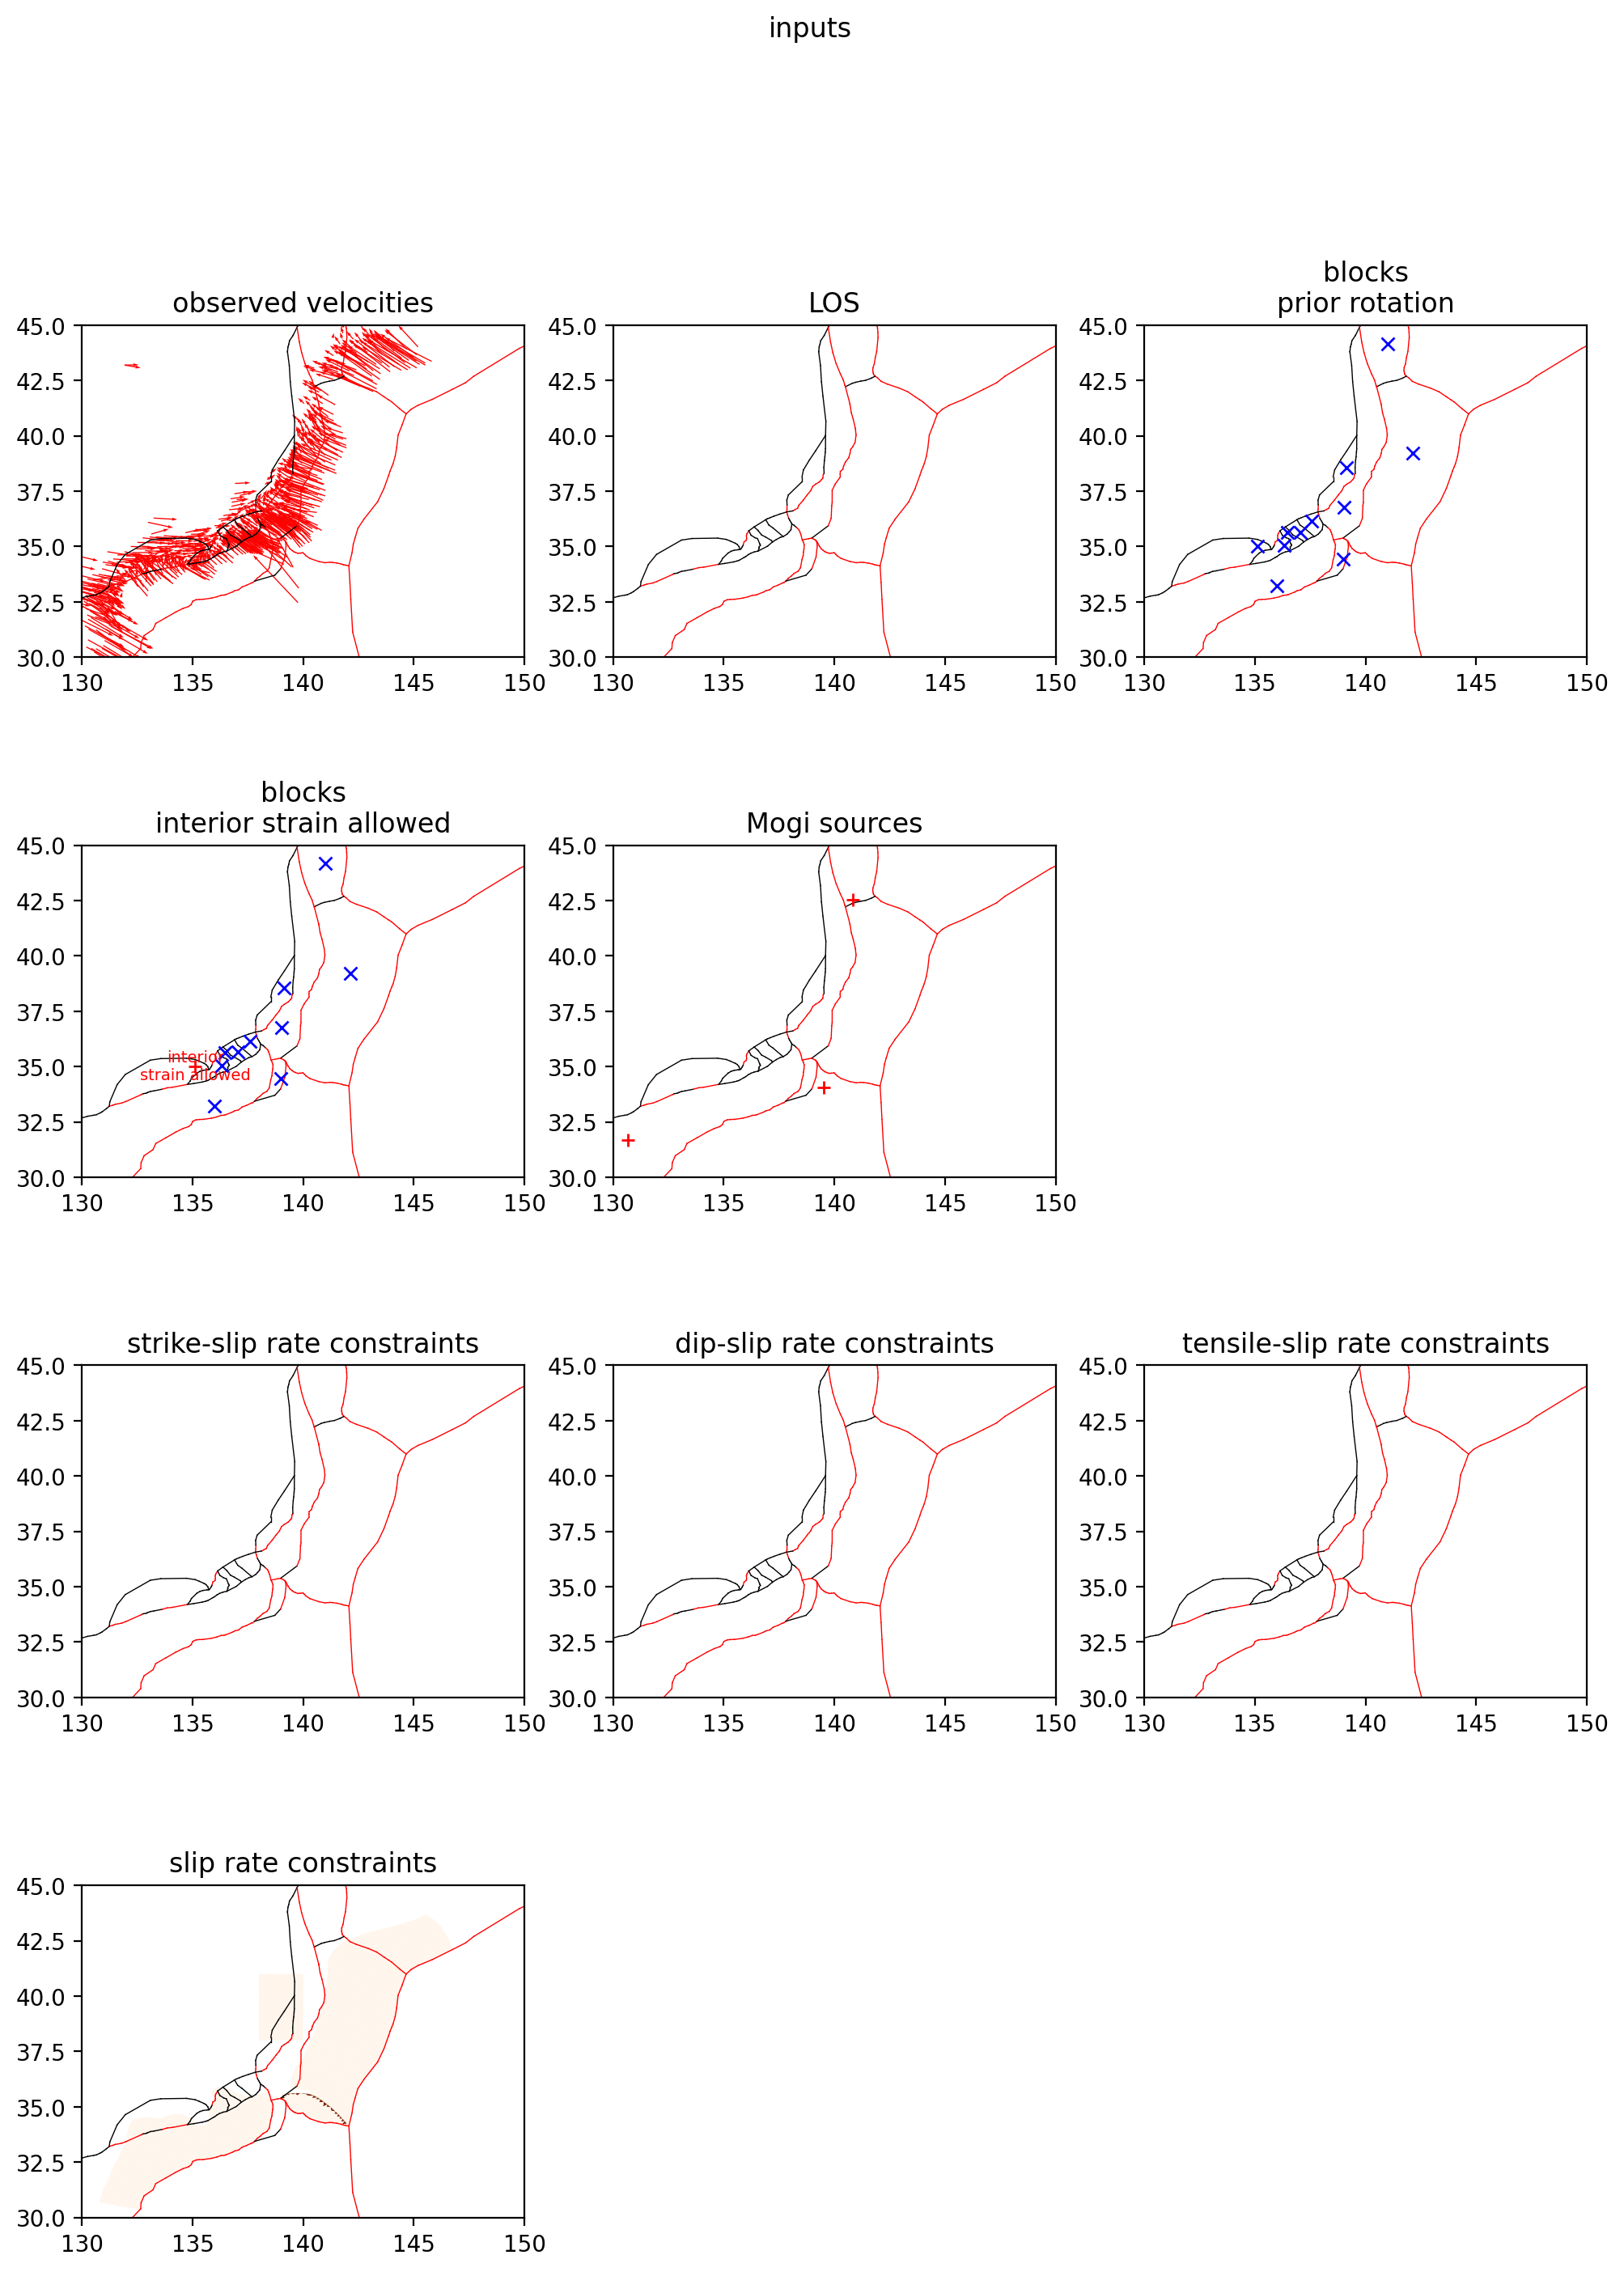

In [7]:
celeri.plot_input_summary(estimation.model)

# Plot model estimation summary


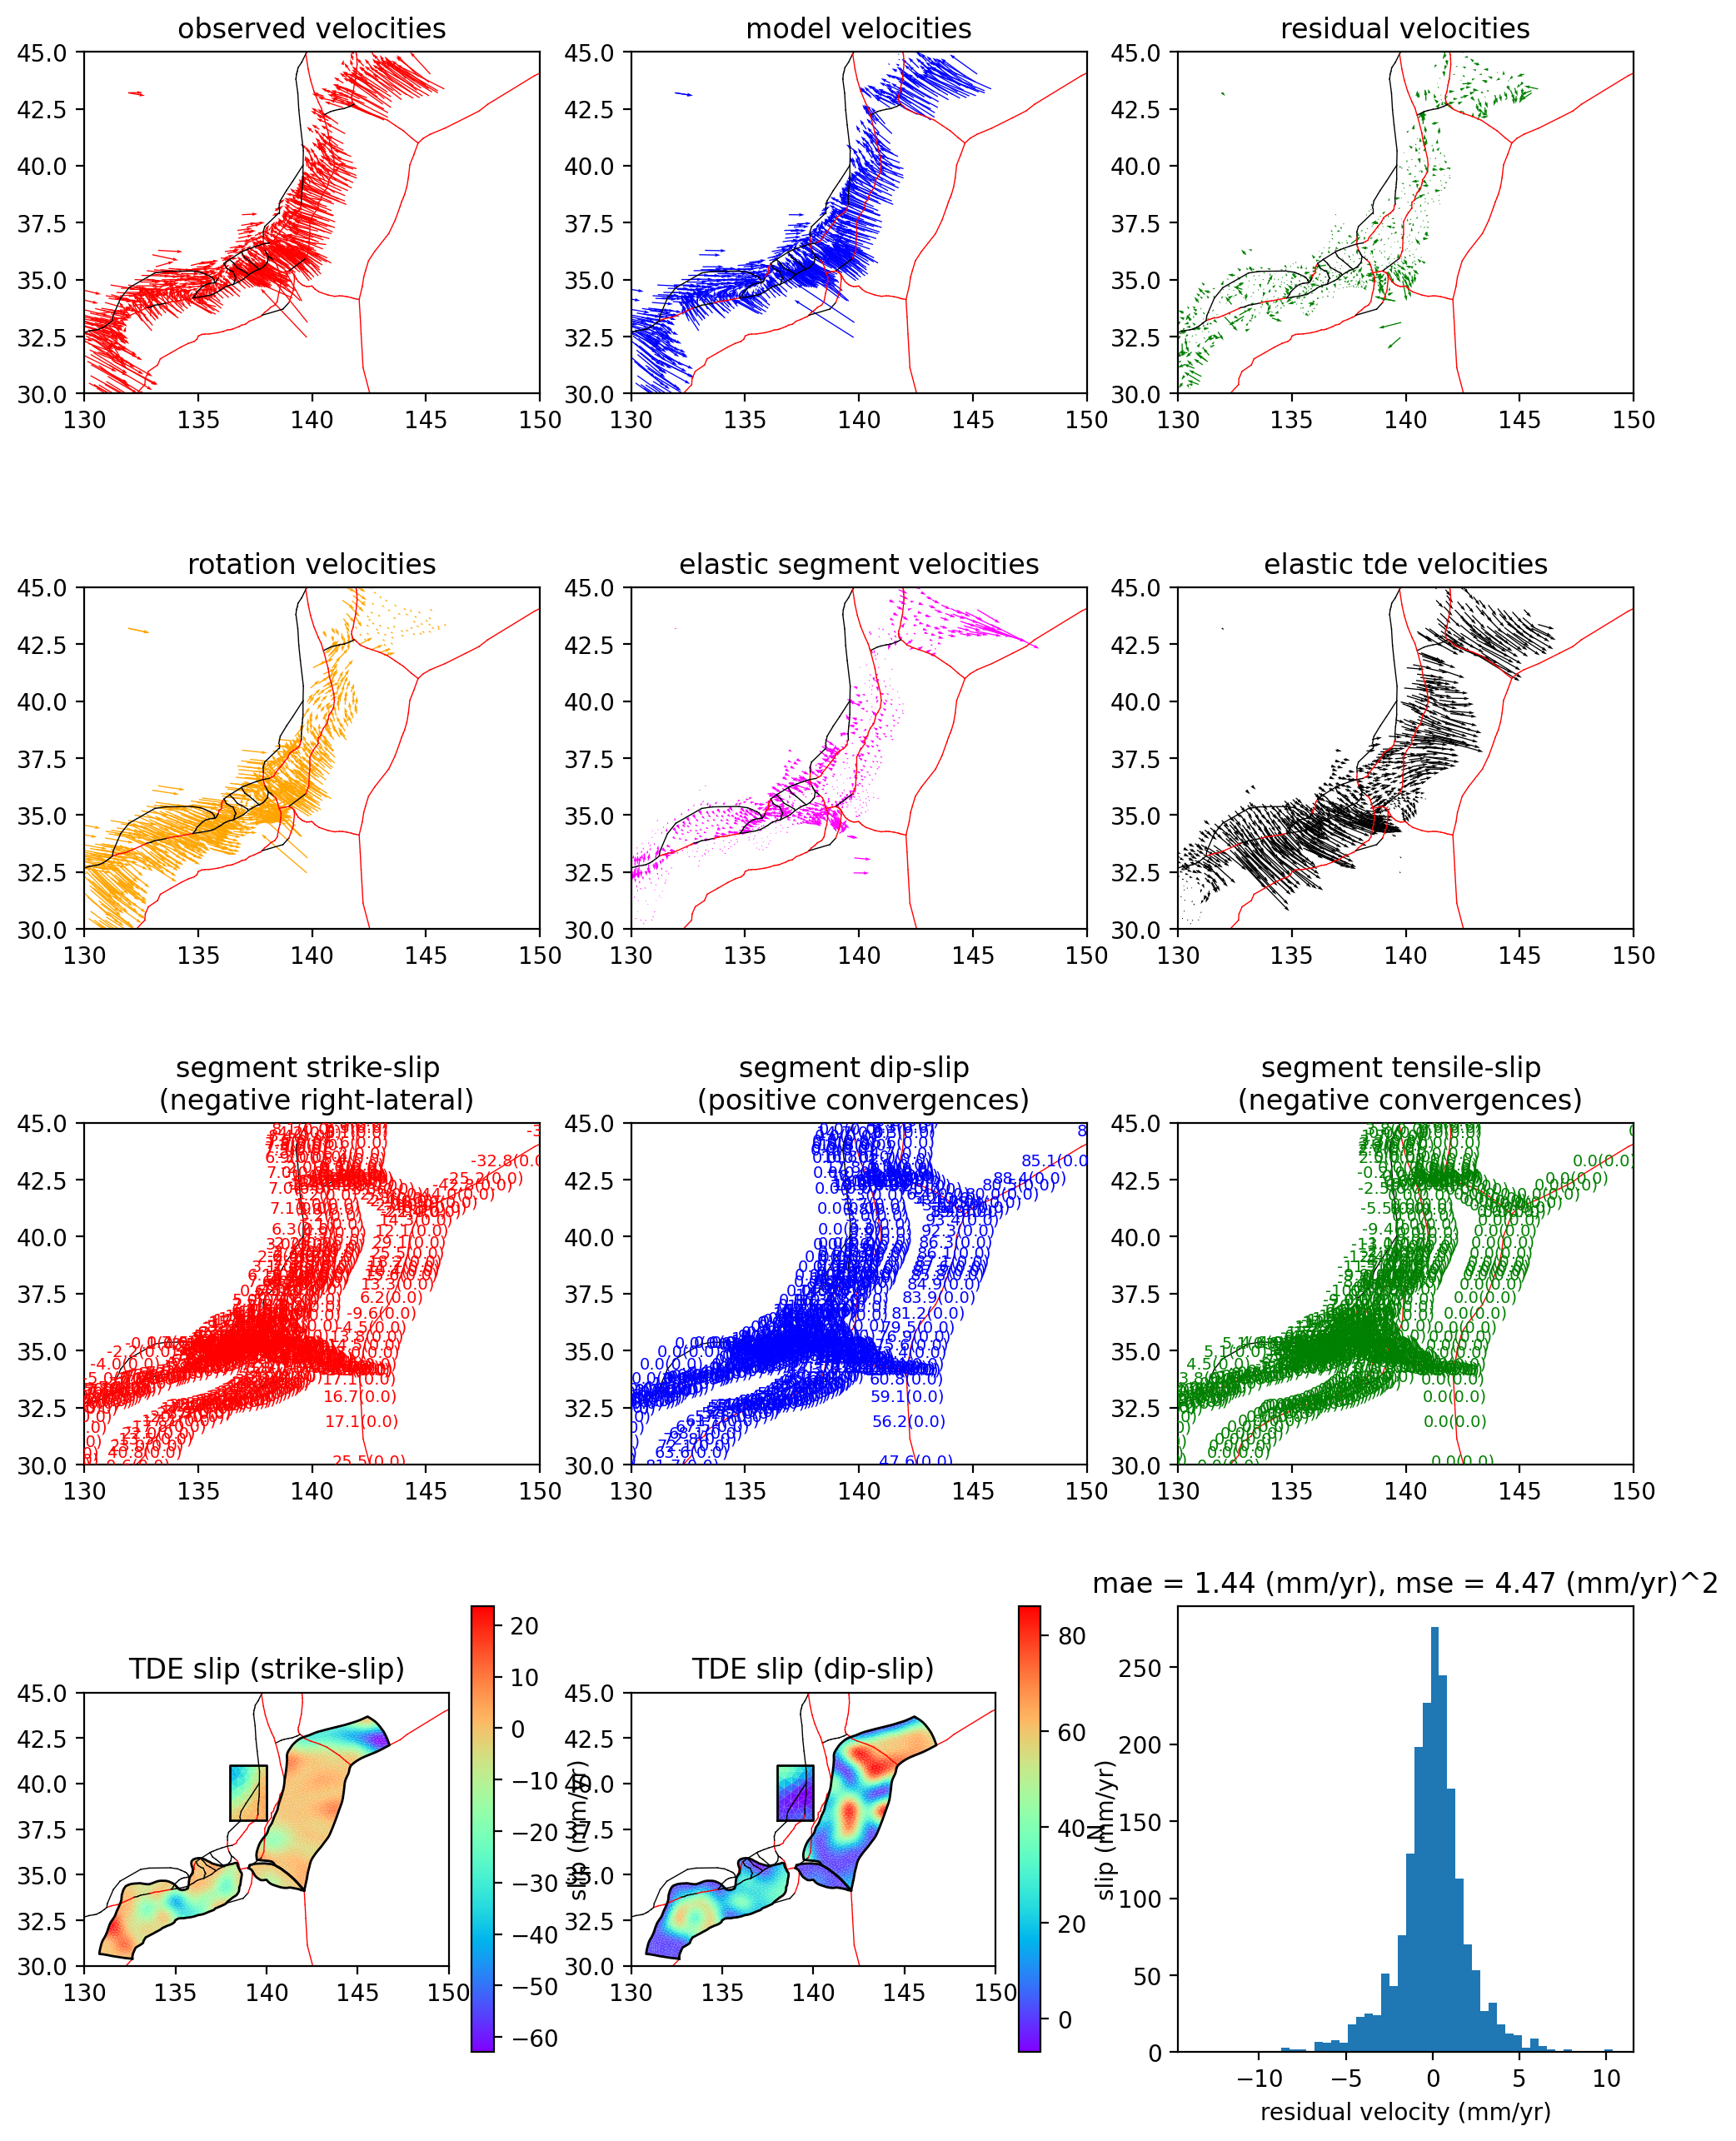

2025-07-16 23:24:21.510 | SUCCESS  | celeri.plot:plot_estimation_summary:684 - Wrote figures /Users/meade/Desktop/celeri/runs/0000000009/plot_estimation_summary.(pdf, png)


In [8]:
celeri.plot_estimation_summary(estimation.model, estimation)

# Observed velocities

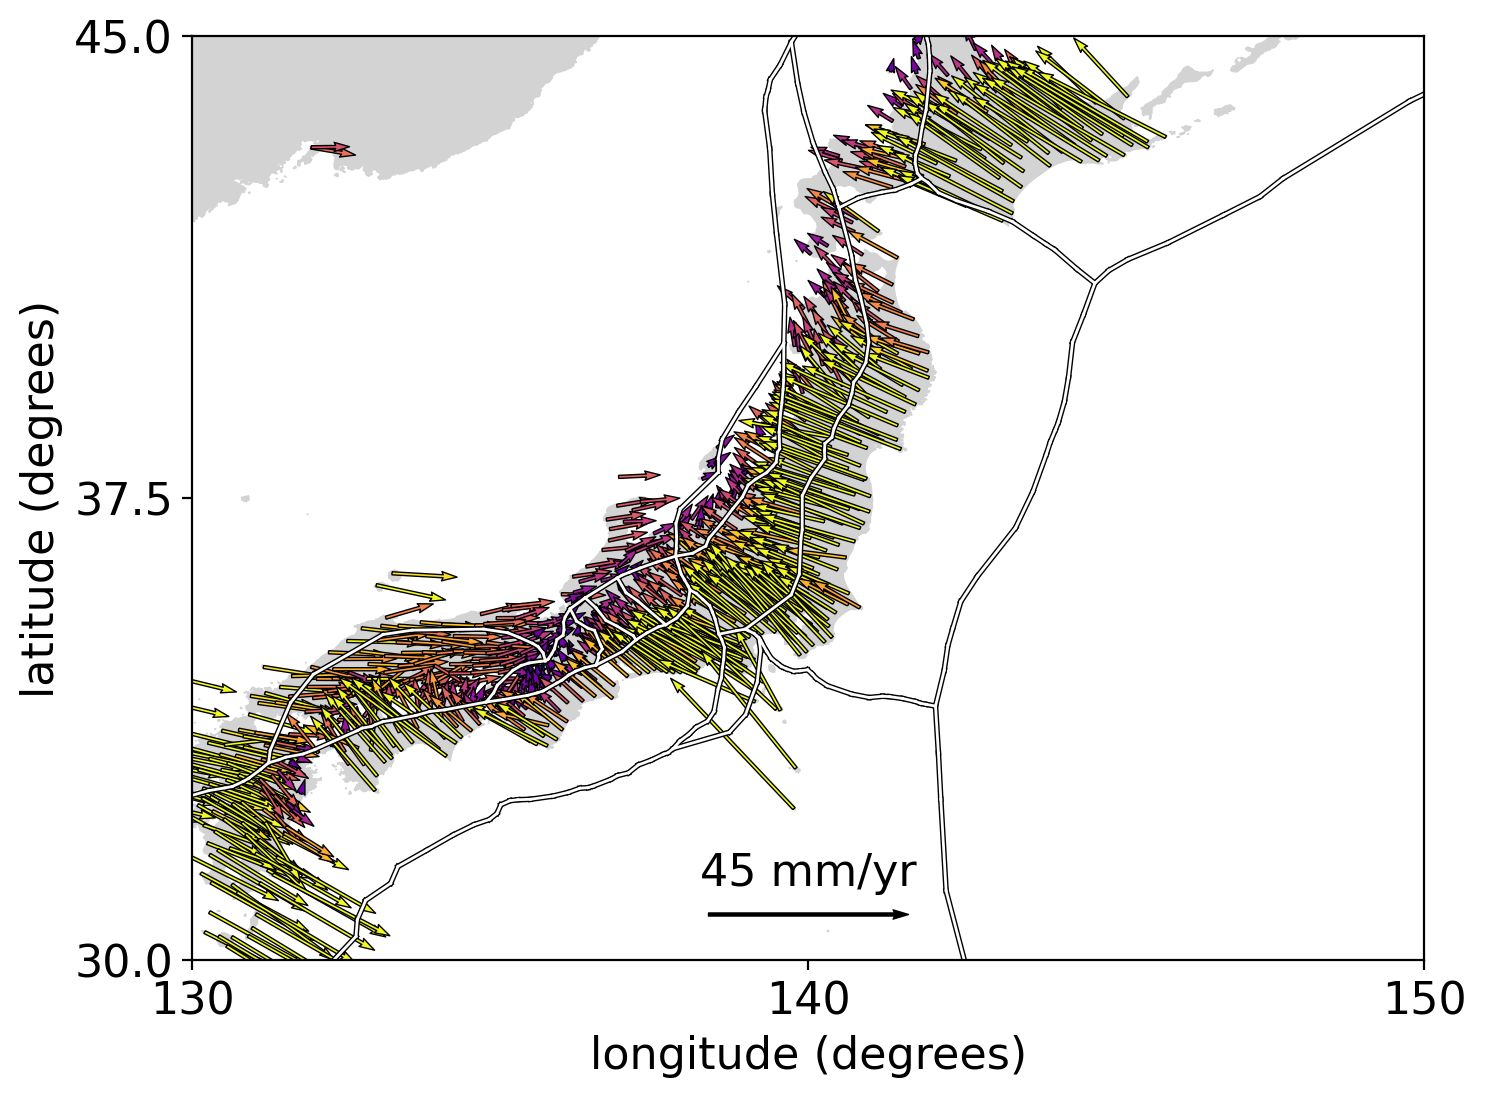

In [9]:
# Observed velocities
plt.figure(figsize=p.figsize_vectors)
plot_segments(p, estimation.model.segment)
common_plot_elements(p)
plot_geography(p, geographic_lons, geographic_lats)
plot_vel_arrows_elements(
    p,
    estimation.model.station,
    estimation.model.station.east_vel,
    estimation.model.station.north_vel,
    arrow_scale=1.0,
)

# Model velocities

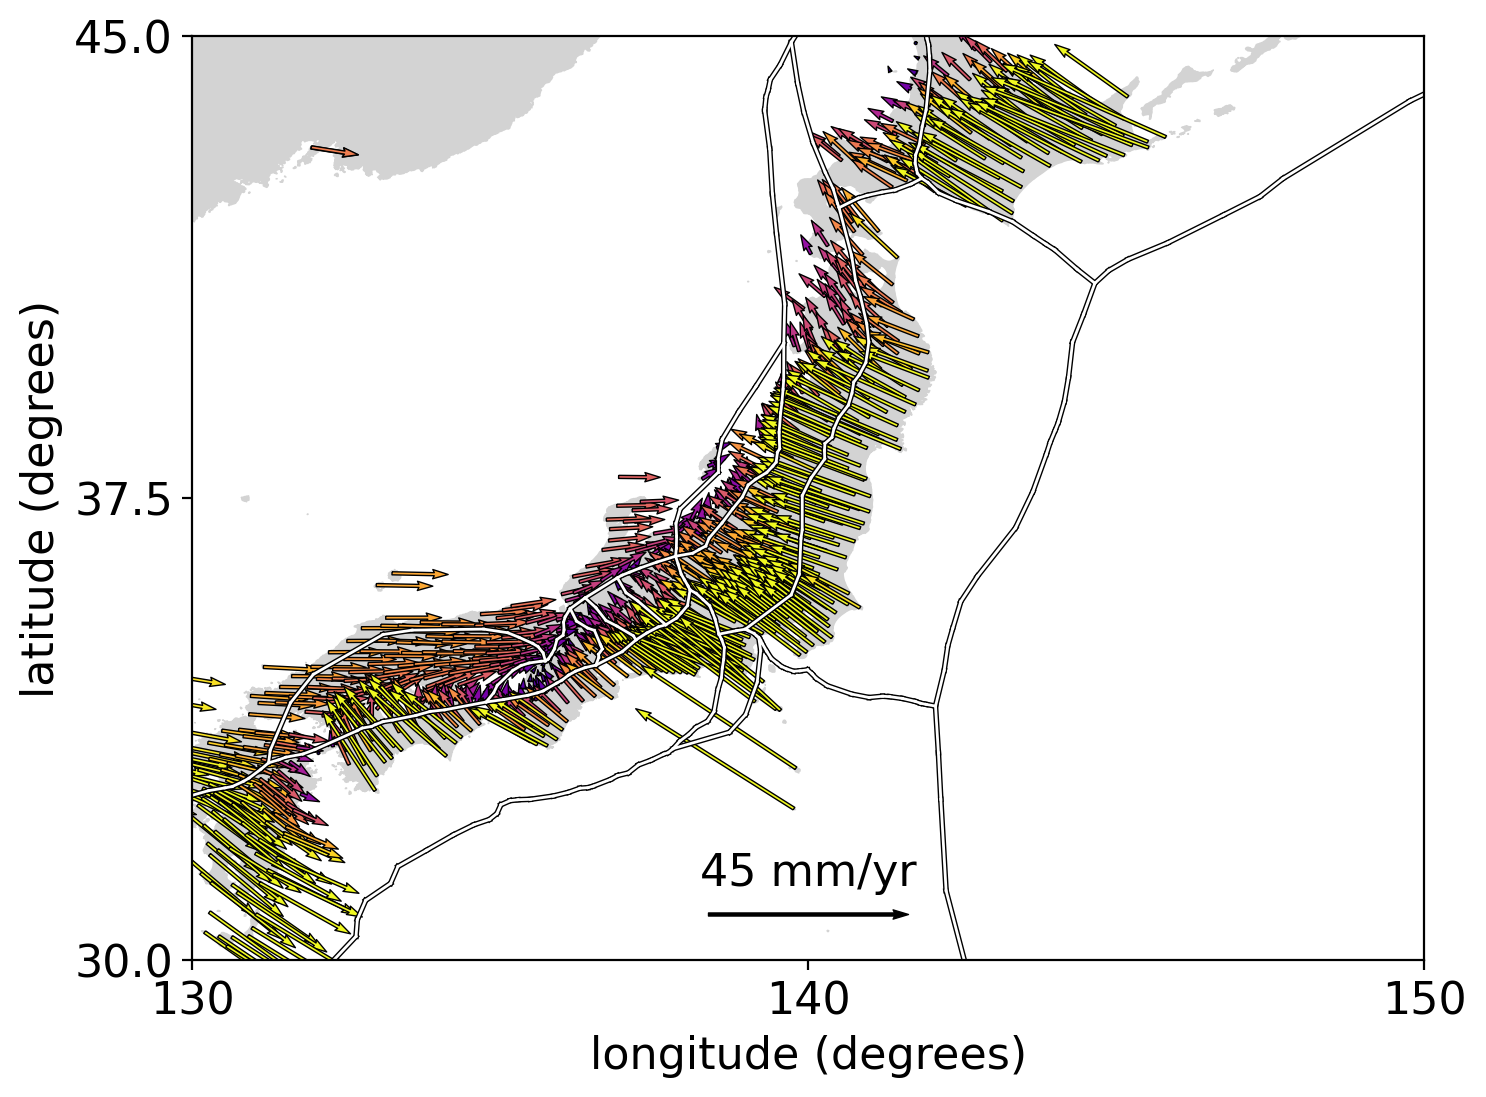

In [10]:
# Model velocities
plt.figure(figsize=p.figsize_vectors)
plot_segments(p, estimation.model.segment)
common_plot_elements(p)
plot_geography(p, geographic_lons, geographic_lats)
plot_vel_arrows_elements(
    p,
    estimation.model.station,
    estimation.east_vel,
    estimation.north_vel,
    arrow_scale=1.0,
)

# Residual velocities

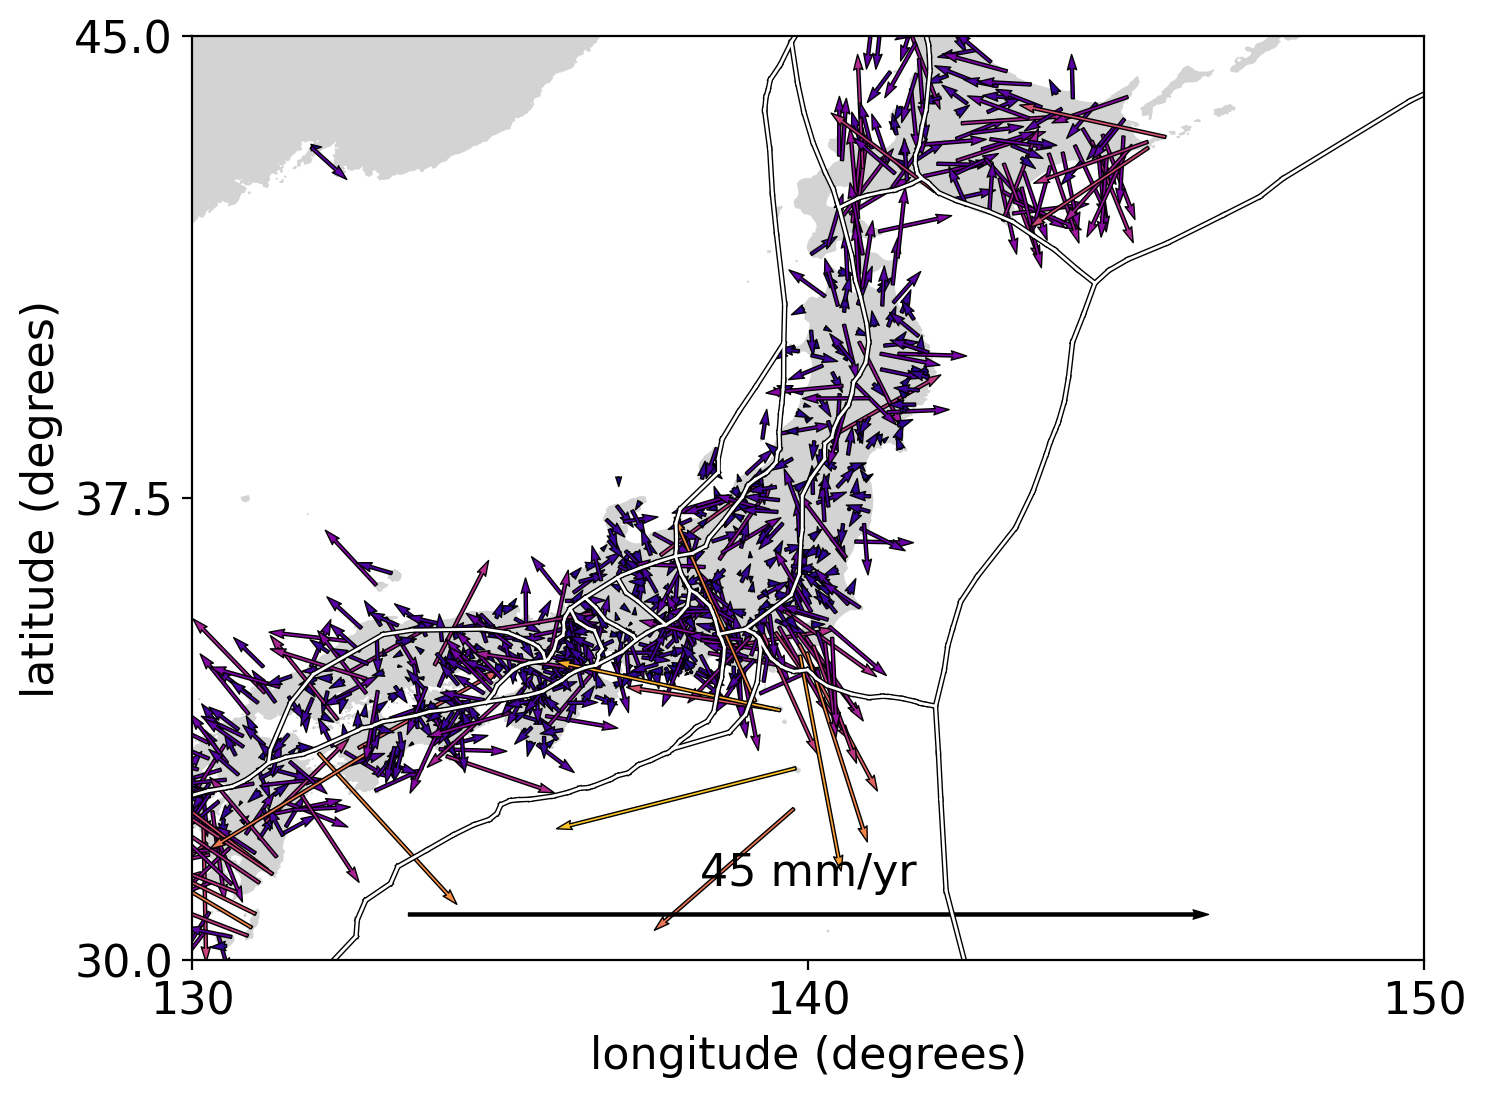

In [11]:
# Residual velocities
plt.figure(figsize=p.figsize_vectors)
plot_segments(p, estimation.model.segment)
common_plot_elements(p)
plot_geography(p, geographic_lons, geographic_lats)
plot_vel_arrows_elements(
    p,
    estimation.model.station,
    estimation.east_vel_residual,
    estimation.north_vel_residual,
    arrow_scale=0.25,
)

# Rotation velocities

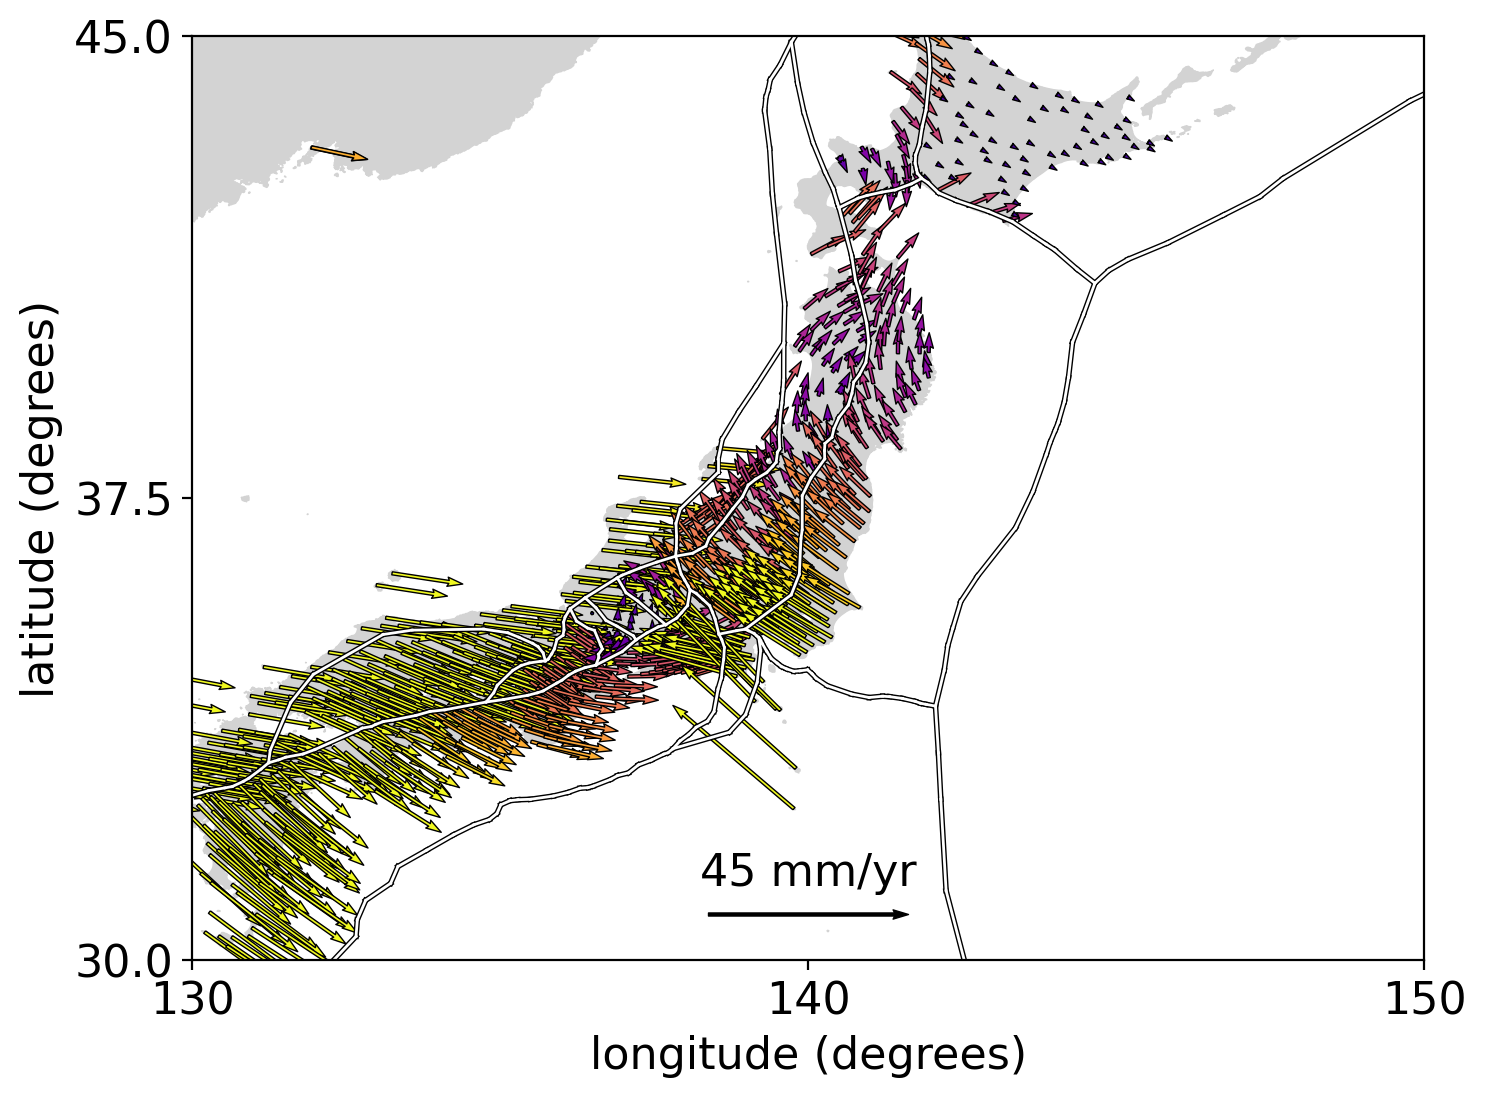

In [12]:
# Rotation velocities
plt.figure(figsize=p.figsize_vectors)
plot_segments(p, estimation.model.segment)
common_plot_elements(p)
plot_geography(p, geographic_lons, geographic_lats)
plot_vel_arrows_elements(
    p,
    estimation.model.station,
    estimation.east_vel_rotation,
    estimation.north_vel_rotation,
    arrow_scale=1.0,
)

# Fully locked segment velocities

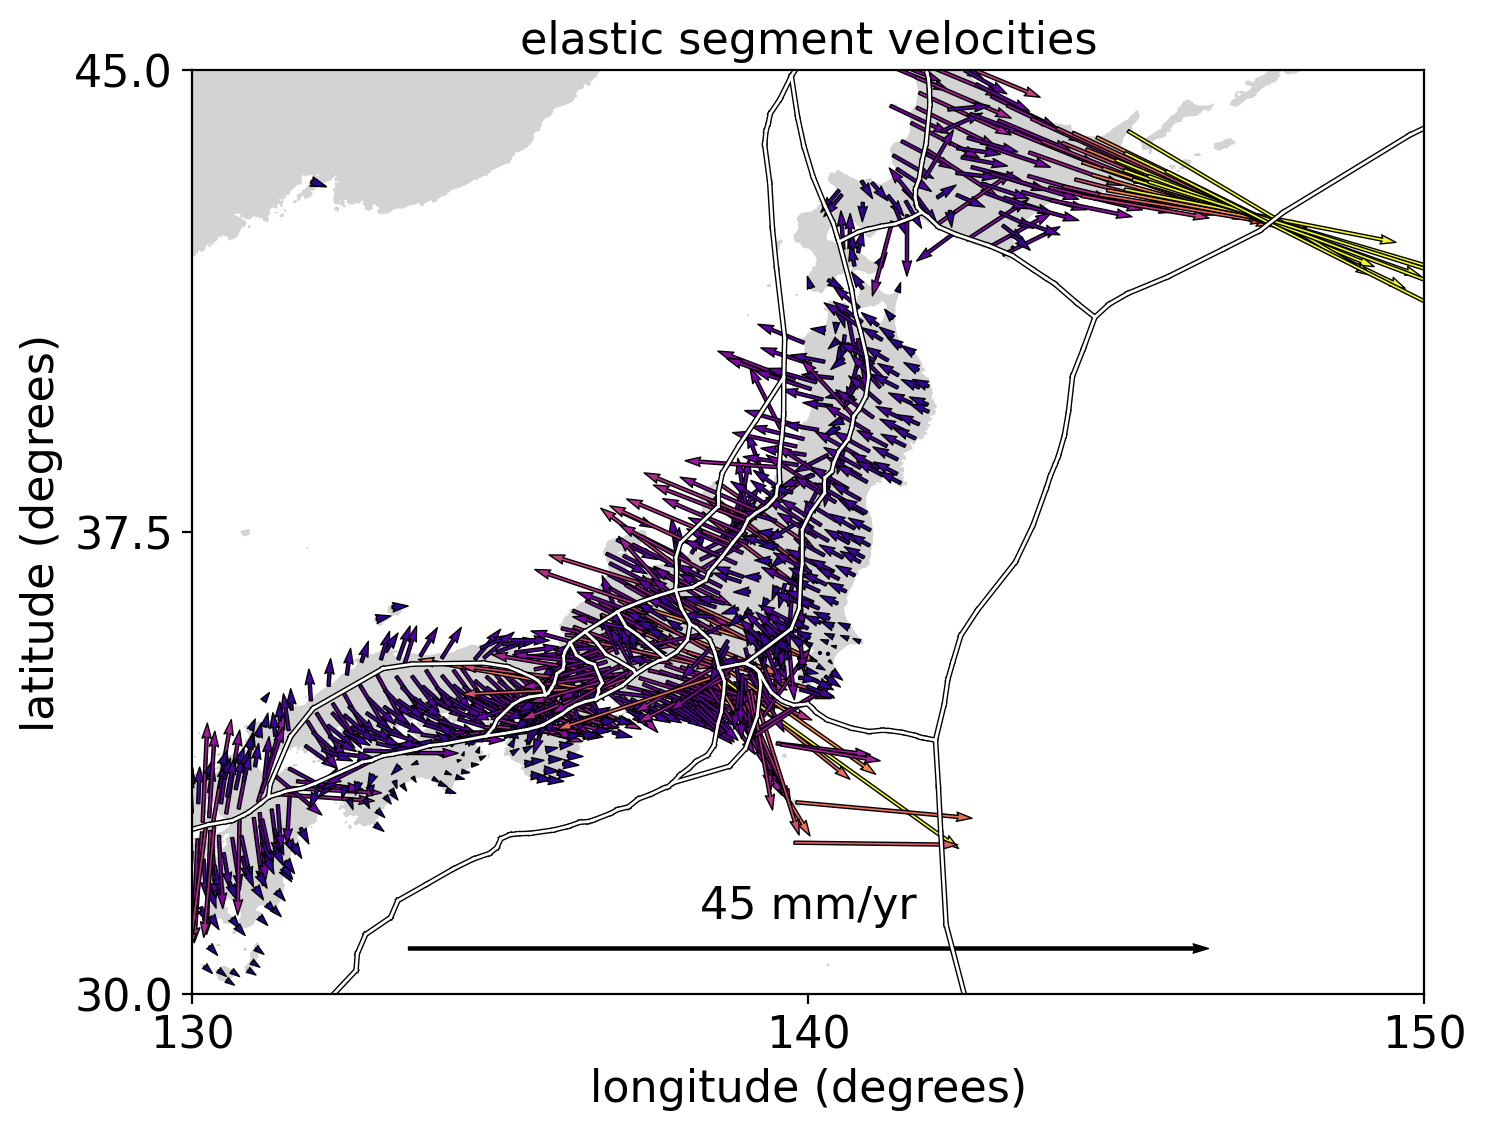

In [13]:
# Elastic segment velocities
plt.figure(figsize=p.figsize_vectors)
plt.title("elastic segment velocities", fontsize=p.fontsize)
plot_segments(p, estimation.model.segment)
common_plot_elements(p)
plot_geography(p, geographic_lons, geographic_lats)
plot_vel_arrows_elements(
    p,
    estimation.model.station,
    estimation.east_vel_elastic_segment,
    estimation.north_vel_elastic_segment,
    arrow_scale=0.25,
)

# Mesh velocities

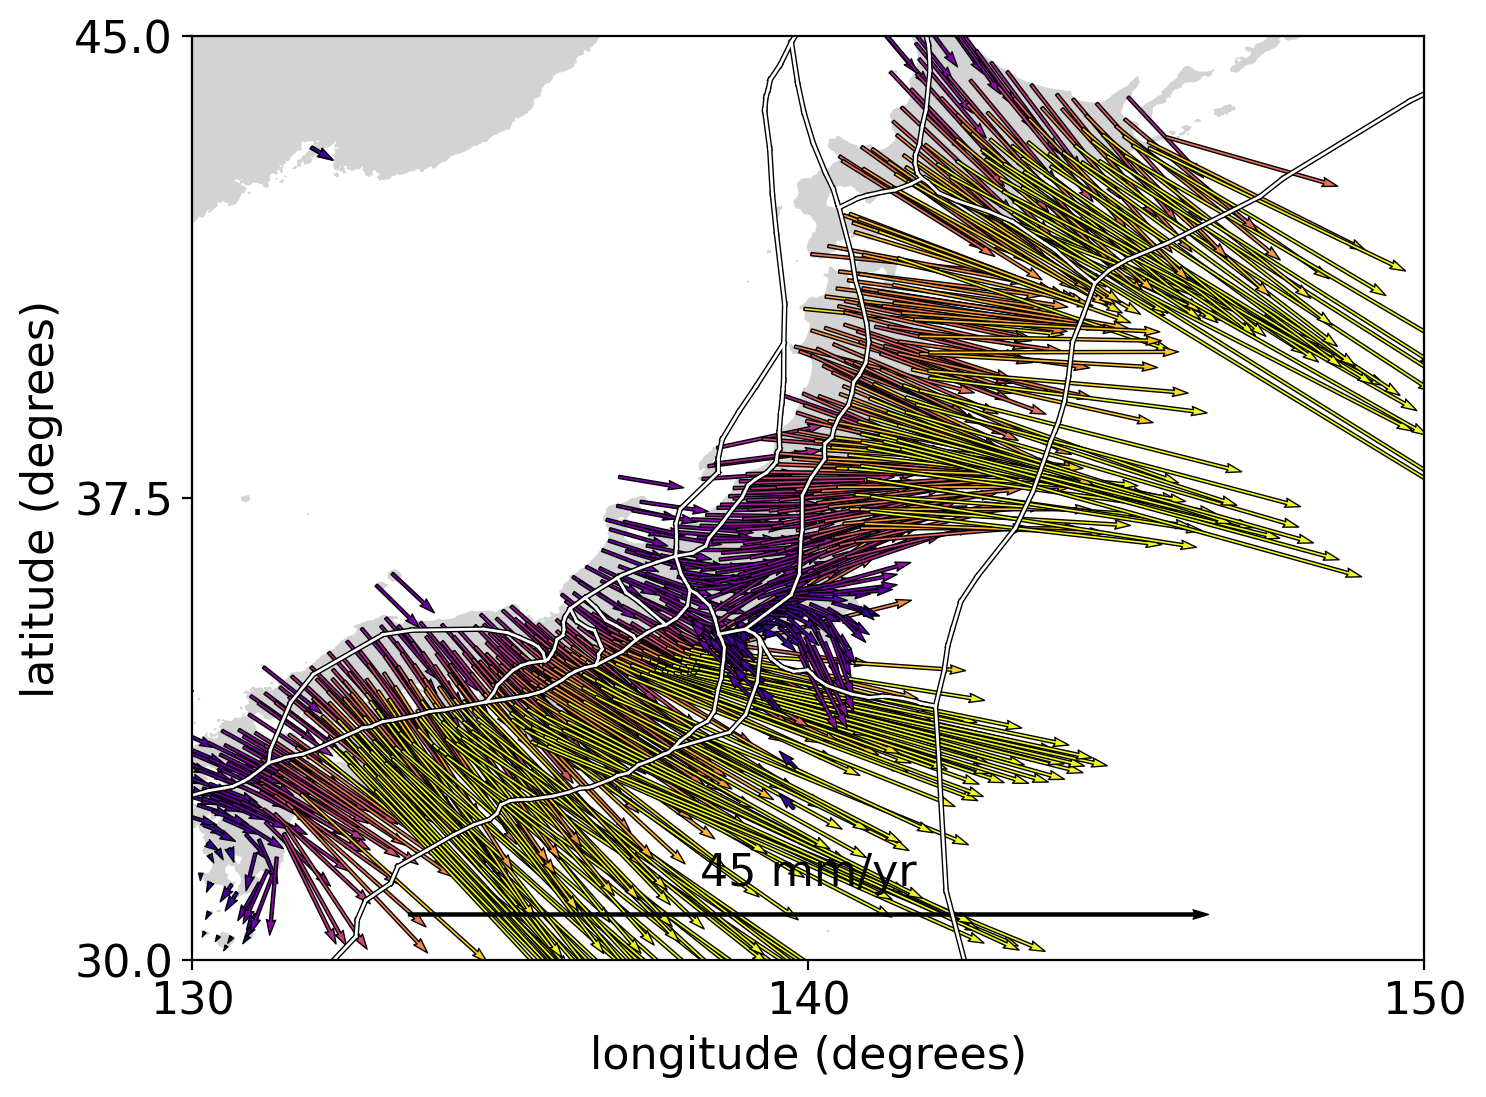

In [14]:
# Elastic tde velocities
plt.figure(figsize=p.figsize_vectors)
plot_segments(p, estimation.model.segment)
common_plot_elements(p)
plot_geography(p, geographic_lons, geographic_lats)
plot_vel_arrows_elements(
    p,
    estimation.model.station,
    estimation.east_vel_tde,
    estimation.north_vel_tde,
    arrow_scale=0.25,
)

# Total elastic velocities

# Strain velocities

# Mogi velocities

# Residual velocity histogram

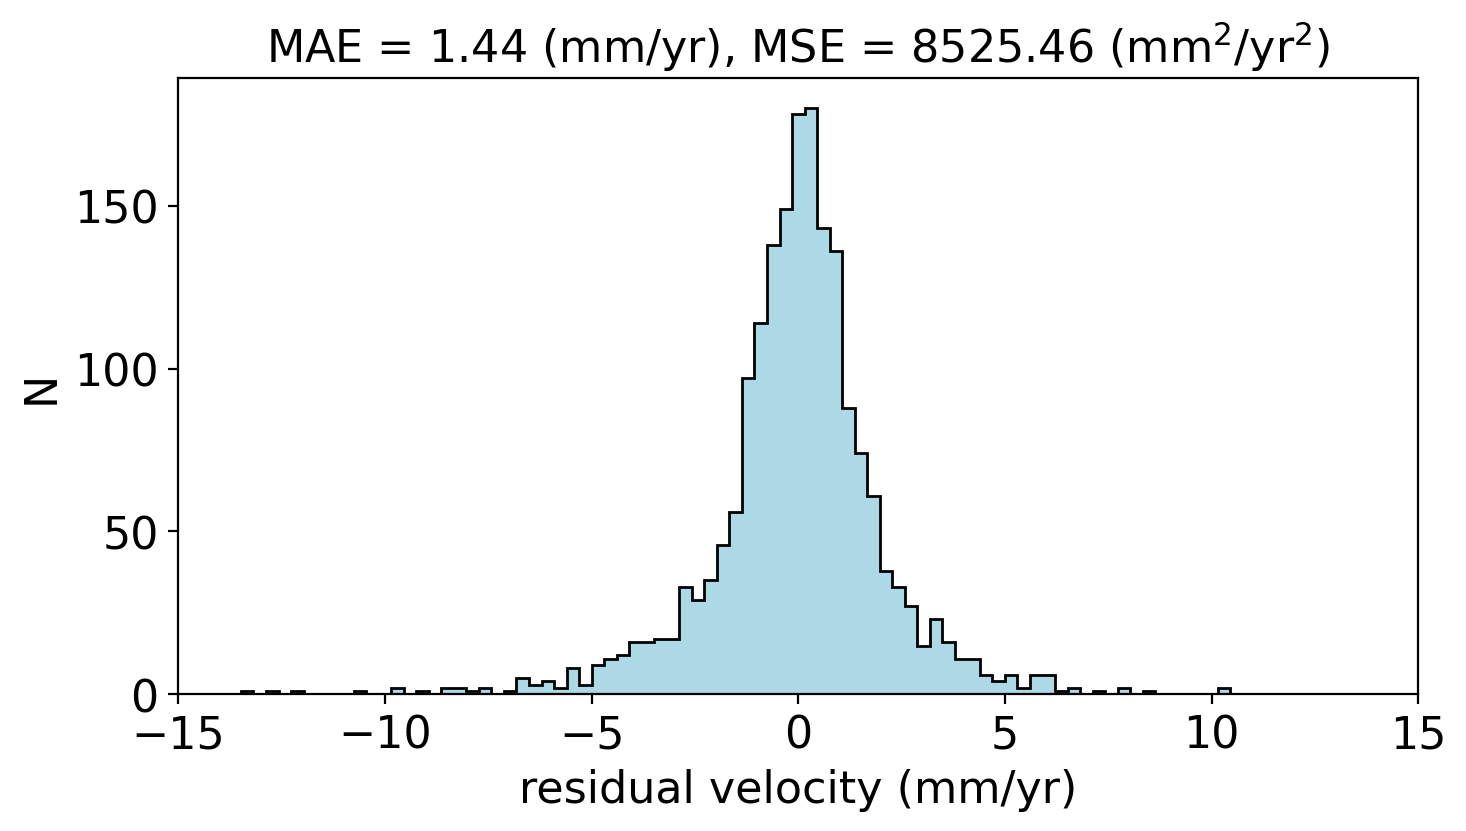

In [15]:
# Residual velocities
residual_velocity_vector = np.concatenate(
    (estimation.east_vel_residual, estimation.north_vel_residual)
)
mean_average_error = np.mean(np.abs(residual_velocity_vector))
mean_squared_error = np.sum(residual_velocity_vector **2.0)

# Histogram parameters
n_bins = 100
bin_edge_min = -15
bin_edge_max = 15
bins = np.linspace(bin_edge_min, bin_edge_max, n_bins)

# Create histogram of residual velocities
plt.figure(figsize=(8, 4))
plt.hist(
    residual_velocity_vector,
    bins,
    histtype="stepfilled",
    color="lightblue",
    edgecolor="k",
)
plt.xlim([bin_edge_min, bin_edge_max])
plt.xlabel("residual velocity (mm/yr)", fontsize=p.fontsize)
plt.ylabel("N", fontsize=p.fontsize)
plt.title(f"MAE = {mean_average_error:.2f} (mm/yr), MSE = {mean_squared_error:.2f} (mm$^2$/yr$^2$)", fontsize=p.fontsize)
plt.tick_params(labelsize=p.fontsize)
plt.show()

# Residual velocity scatter plot

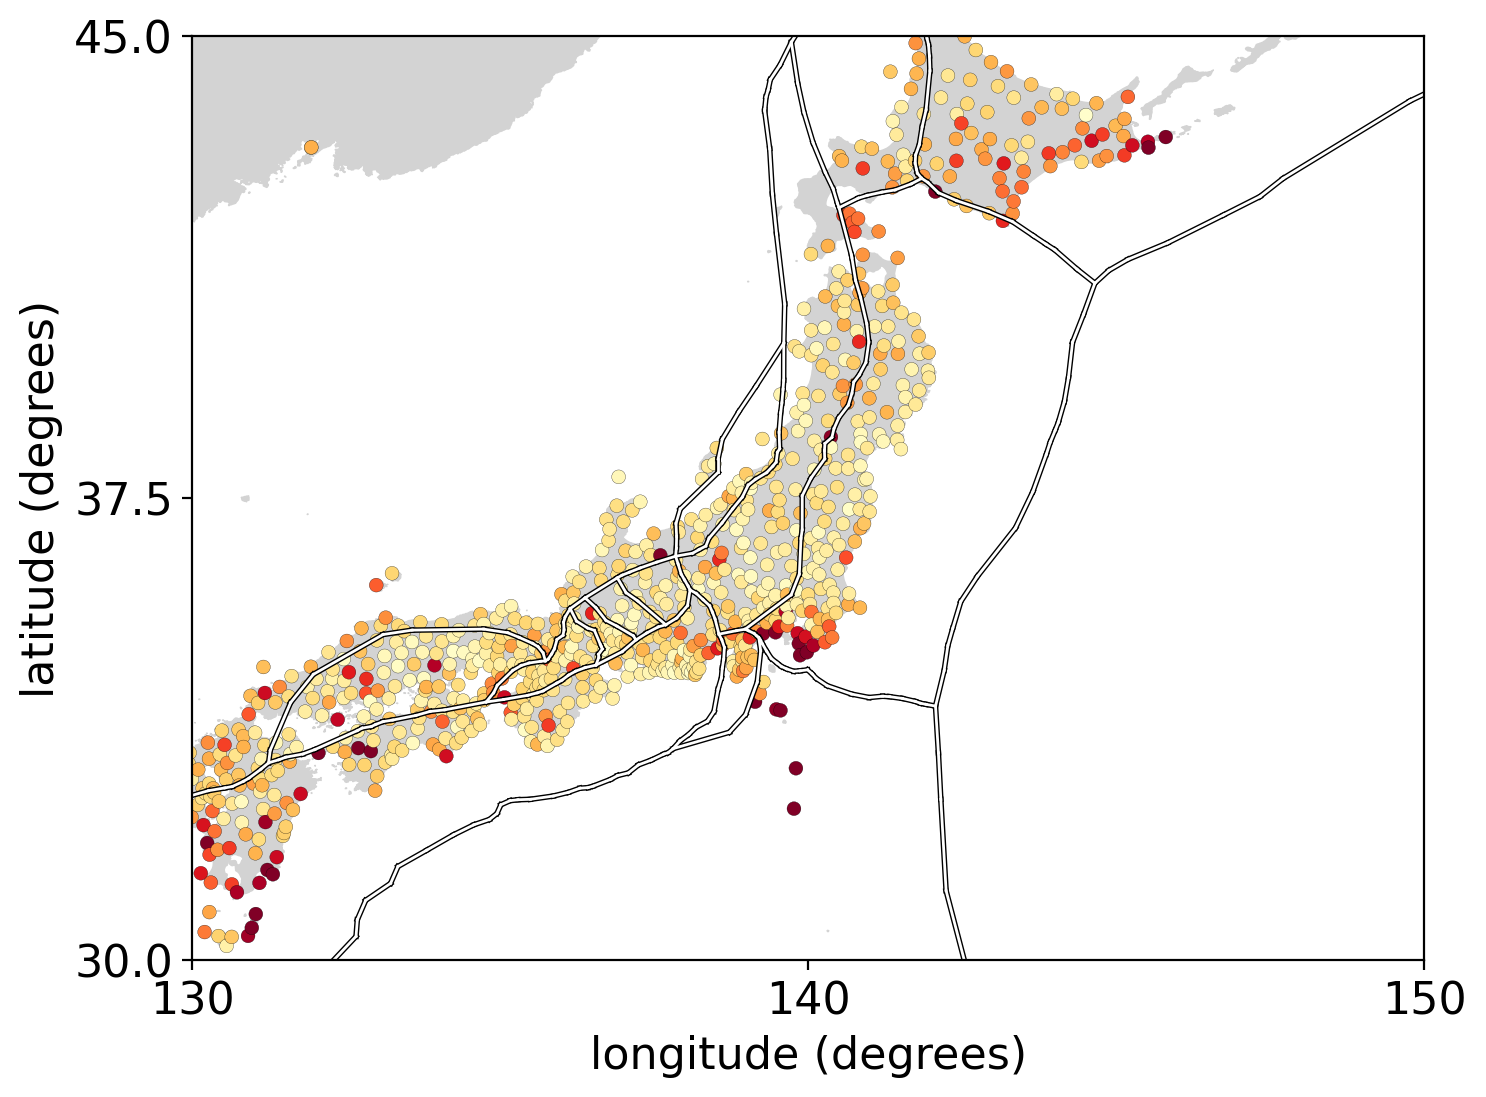

In [16]:
# Scatter plot for velocity estimate errors
mae_station = np.abs(estimation.east_vel_residual) + np.abs(
    estimation.north_vel_residual
)
fig = plt.figure(figsize=p.figsize_vectors)
plot_segments(p, estimation.model.segment)
common_plot_elements(p)
plot_geography(p, geographic_lons, geographic_lats)

# Residual velocity mean average error
plt.scatter(
    estimation.model.station.lon,
    estimation.model.station.lat,
    s=25,
    edgecolors="k",
    c=mae_station,
    cmap="YlOrRd",
    linewidths=0.1,
)
plt.clim(0, 10)

# Draw white background rectangle
rect = mpatches.Rectangle(
    p.key_rectangle_anchor,
    p.key_rectangle_width,
    p.key_rectangle_height,
    fill=True,
    color=p.key_background_color,
    linewidth=p.key_linewidth,
    ec=p.key_edgecolor,
)
plt.gca().add_patch(rect)
plt.show()

# Fault slip rates (strike-slip)
# TODO: Try tab:orange, tab:blue

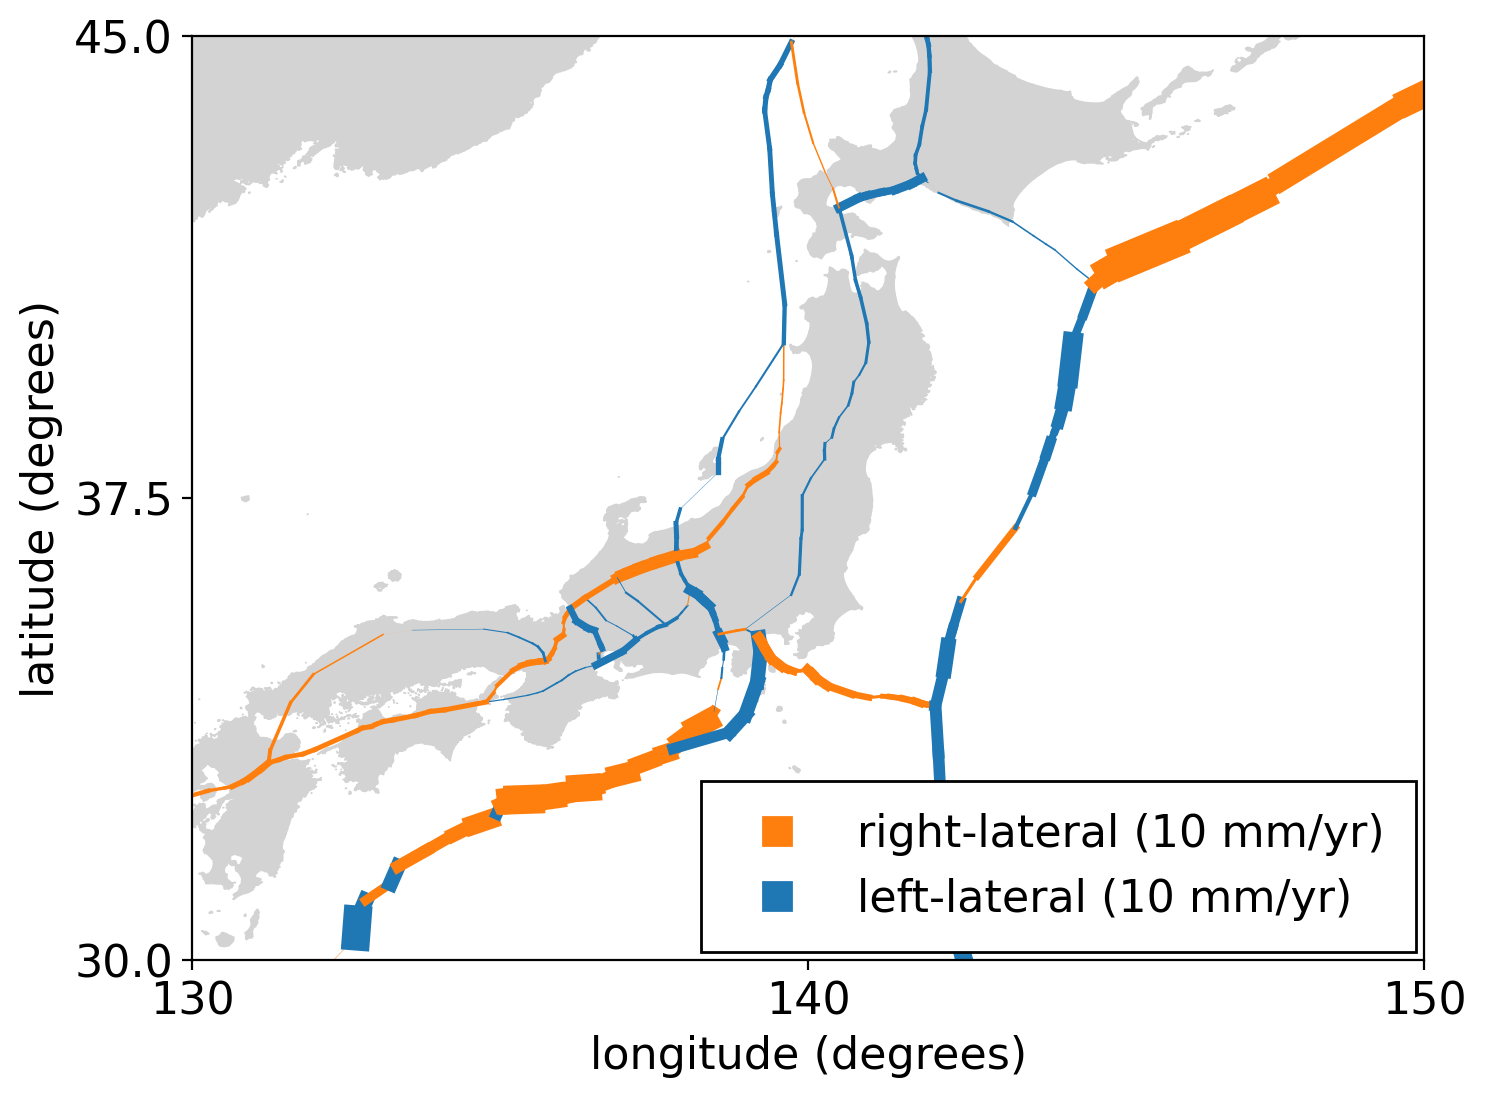

In [17]:
# Plot estimated strike-slip rates
slip_rate_width_scale = 0.25

plt.figure(figsize=p.figsize_vectors)
# plt.title("strike-slip rates", fontsize=p.fontsize)
common_plot_elements(p)
plot_geography(p, geographic_lons, geographic_lats)

# Plot fault slip rates
for i in range(len(estimation.model.segment)):
    if estimation.strike_slip_rates[i] < 0:
        plt.plot(
            [estimation.model.segment.lon1[i], estimation.model.segment.lon2[i]],
            [estimation.model.segment.lat1[i], estimation.model.segment.lat2[i]],
            "-", color="tab:orange",
            linewidth=slip_rate_width_scale * estimation.strike_slip_rates[i],
        )
    else:
        plt.plot(
            [estimation.model.segment.lon1[i], estimation.model.segment.lon2[i]],
            [estimation.model.segment.lat1[i], estimation.model.segment.lat2[i]],
            "-", color="tab:blue",
            linewidth=slip_rate_width_scale * estimation.strike_slip_rates[i],
        )

# Legend
blue_segments = mlines.Line2D(
    [],
    [],
    color="tab:orange",
    marker="s",
    linestyle="None",
    markersize=10,
    label="right-lateral (10 mm/yr)",
)
red_segments = mlines.Line2D(
    [],
    [],
    color="tab:blue",
    marker="s",
    linestyle="None",
    markersize=10,
    label="left-lateral (10 mm/yr)",
)
plt.legend(
    handles=[blue_segments, red_segments],
    loc="lower right",
    fontsize=p.fontsize,
    framealpha=1.0,
    edgecolor="k",
).get_frame().set_boxstyle("Square")

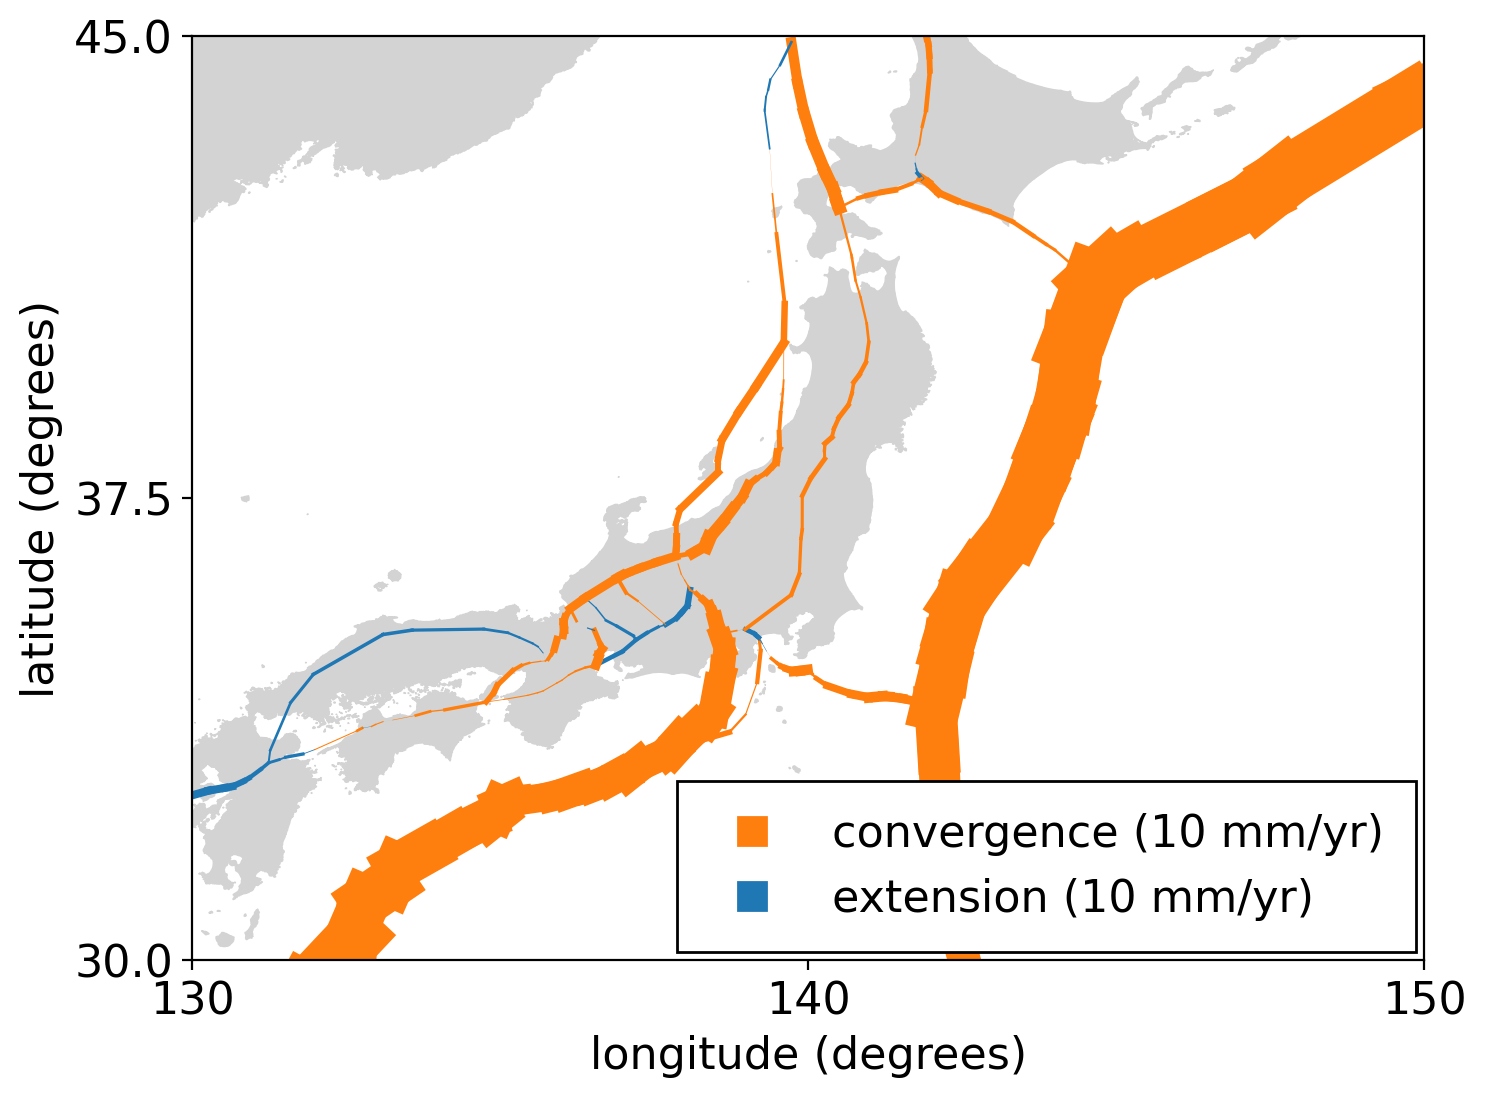

In [18]:
# Scaling factor for slip rate widths
slip_rate_width_scale = 0.25

# Plot estimated dip/tensile-slip rates
plt.figure(figsize=p.figsize_vectors)
common_plot_elements(p)
plot_geography(p, geographic_lons, geographic_lats)

for i in range(len(estimation.model.segment)):
    if estimation.dip_slip_rates[i] > 0:
        plt.plot(
            [estimation.model.segment.lon1[i], estimation.model.segment.lon2[i]],
            [estimation.model.segment.lat1[i], estimation.model.segment.lat2[i]],
            "-", color="tab:orange",
            linewidth=slip_rate_width_scale * estimation.dip_slip_rates[i],
        )
    else:
        plt.plot(
            [estimation.model.segment.lon1[i], estimation.model.segment.lon2[i]],
            [estimation.model.segment.lat1[i], estimation.model.segment.lat2[i]],
            "-", color="tab:blue",
            linewidth=slip_rate_width_scale * estimation.dip_slip_rates[i],
        )

for i in range(len(estimation.model.segment)):
    if estimation.tensile_slip_rates[i] < 0:
        plt.plot(
            [estimation.model.segment.lon1[i], estimation.model.segment.lon2[i]],
            [estimation.model.segment.lat1[i], estimation.model.segment.lat2[i]],
            "-", color="tab:orange",
            linewidth=slip_rate_width_scale * estimation.tensile_slip_rates[i],
        )
    else:
        plt.plot(
            [estimation.model.segment.lon1[i], estimation.model.segment.lon2[i]],
            [estimation.model.segment.lat1[i], estimation.model.segment.lat2[i]],
            "-", color="tab:blue",
            linewidth=slip_rate_width_scale * estimation.tensile_slip_rates[i],
        )


# Legend
black_segments = mlines.Line2D(
    [],
    [],
    color="tab:orange",
    marker="s",
    linestyle="None",
    markersize=10,
    label="convergence (10 mm/yr)",
)
red_segments = mlines.Line2D(
    [],
    [],
    color="tab:blue",
    marker="s",
    linestyle="None",
    markersize=10,
    label="extension (10 mm/yr)",
)
plt.legend(
    handles=[black_segments, red_segments],
    loc="lower right",
    fontsize=p.fontsize,
    framealpha=1.0,
    edgecolor="k",
).get_frame().set_boxstyle("Square")

# Quick mesh plots

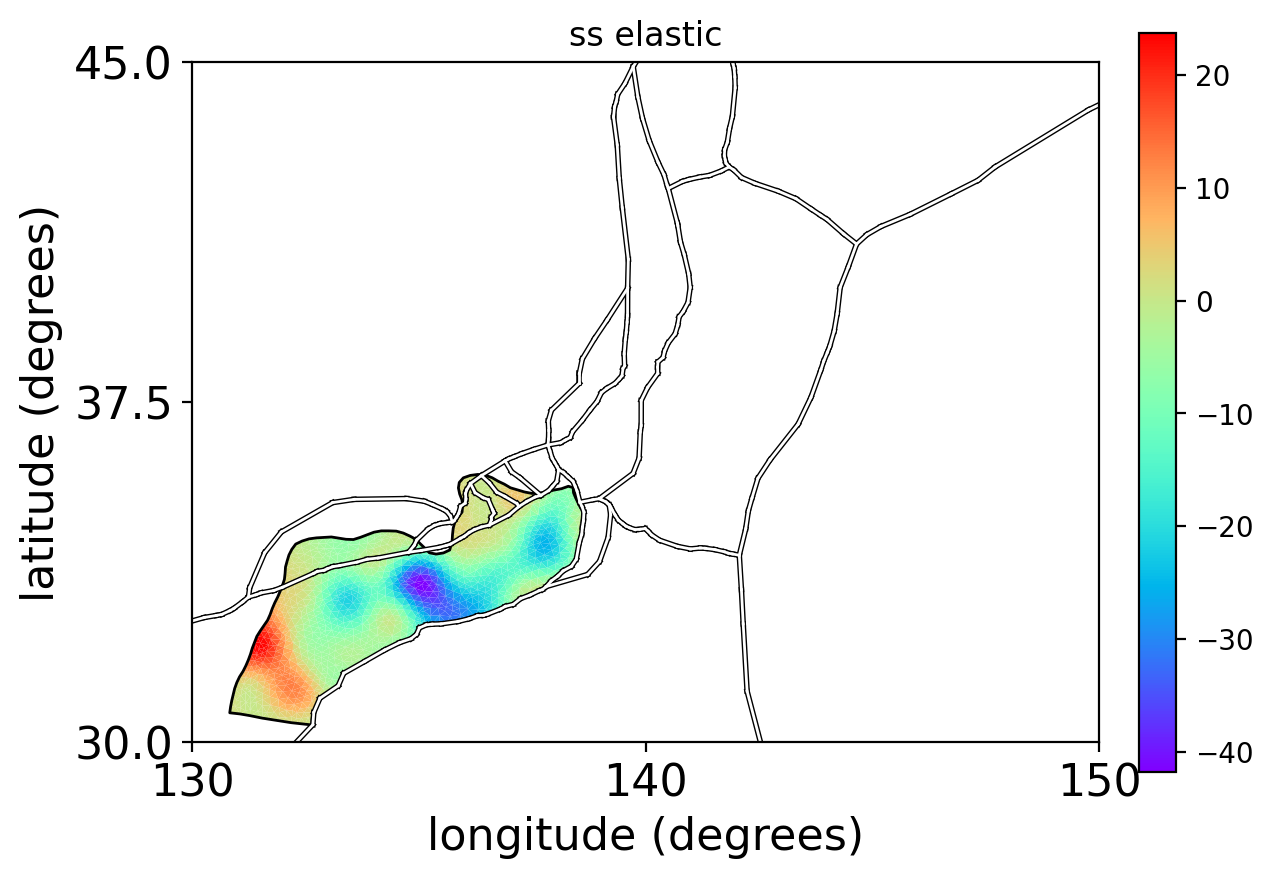

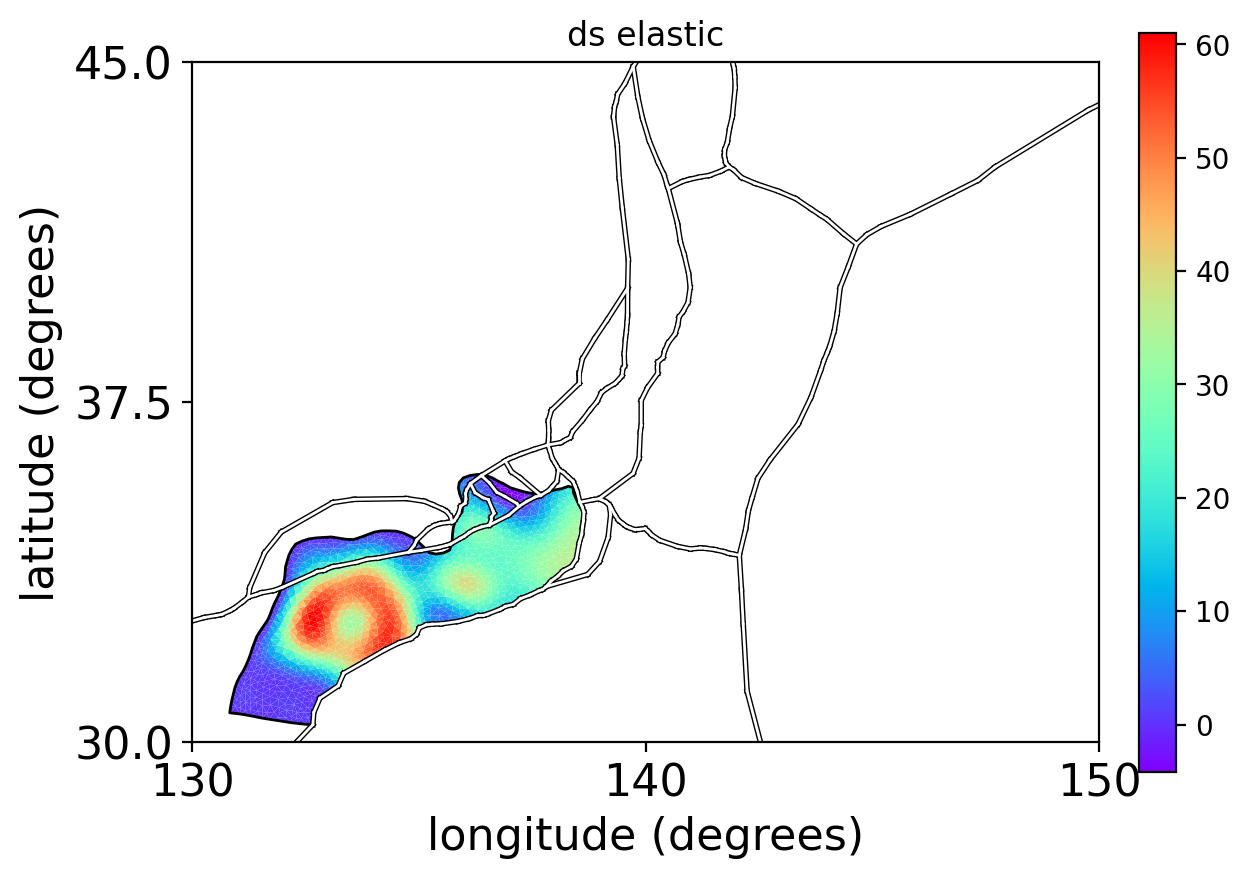

In [20]:
# TODO: Modify with axes flags

# Strike-slip
mesh_idx = 0
plot_mesh(estimation.model.meshes[mesh_idx], estimation.tde_strike_slip_rates[mesh_start_idx[mesh_idx]:mesh_end_idx[mesh_idx]])
plot_segments(p, estimation.model.segment)
common_plot_elements(p)
plt.gca().set_aspect("equal")
plt.title("ss elastic")
plt.show()

# Dip-slip
plot_mesh(estimation.model.meshes[mesh_idx], estimation.tde_dip_slip_rates[mesh_start_idx[mesh_idx]:mesh_end_idx[mesh_idx]])
plot_segments(p, estimation.model.segment)
common_plot_elements(p)
plt.gca().set_aspect("equal")
plt.title("ds elastic")
plt.show()


In [22]:
# import matplotlib
# import warnings
# from scipy.interpolate import RBFInterpolator
# from matplotlib import path
# import scipy.io as sio
# import pandas as pd

# estimation_qp = estimation
# config = model.config
# block = model.block
# index = operators.index
# meshes = model.meshes
# segment = model.segment

# MAX_VEL = 60

# n_grid_x = 500
# n_grid_y = 500


# def inpolygon(xq, yq, xv, yv):
#     shape = xq.shape
#     xq = xq.reshape(-1)
#     yq = yq.reshape(-1)
#     xv = xv.reshape(-1)
#     yv = yv.reshape(-1)
#     q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
#     p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
#     return p.contains_points(q).reshape(shape)


# def rbf_interpolate():
#     # Observation coordinates and data
#     # x_vec = np.linspace(231, 239, n_grid_x)
#     # y_vec = np.linspace(38, 52, n_grid_y)
#     x_vec = np.linspace(130, 140, n_grid_x)
#     y_vec = np.linspace(30, 37, n_grid_y)
#     x_mat, y_mat = np.meshgrid(x_vec, y_vec)
#     y_mat = y_mat
#     centroids_lon = meshes[0].centroids[:, 0]
#     centroids_lat = meshes[0].centroids[:, 1]
#     centroids_val = fill_value

#     # Package for RBFInterpolator
#     xgrid = np.stack((x_mat, y_mat))
#     xflat = xgrid.reshape(2, -1).T
#     xobs = np.vstack((centroids_lon, centroids_lat)).T
#     yobs = centroids_val
#     yflat = RBFInterpolator(xobs, yobs, kernel="cubic", smoothing=0.01, epsilon=1.5)(
#         xflat
#     )
#     ygrid = yflat.reshape(n_grid_x, n_grid_y)
#     return xgrid, ygrid


# def common_plot_elements(segment, lon_range, lat_range):
#     """Elements common to all subplots
#     Args:
#         segment (pd.DataFrame): Fault segments
#         lon_range (Tuple): Longitude range (min, max)
#         lat_range (Tuple): Latitude range (min, max)
#     """
#     WORLD_BOUNDARIES = sio.loadmat("WorldHiVectors.mat")
#     plt.plot(
#         WORLD_BOUNDARIES["lon"],
#         WORLD_BOUNDARIES["lat"],
#         color="gray",
#         linewidth=0.25,
#     )
#     plt.xlim([lon_range[0], lon_range[1]])
#     plt.ylim([lat_range[0], lat_range[1]])
#     plt.xticks([lon_range[0], lon_range[1]])
#     plt.yticks([lat_range[0], lat_range[1]])
#     plt.gca().set_aspect("equal", adjustable="box")


# lon_range = [130, 139]
# lat_range = [30, 37]
# quiver_scale = 0.5 * config.quiver_scale

# mesh_idx = 0

# kinematic = (
#     operators.rotation_to_tri_slip_rate[mesh_idx]
#     @ estimation_qp.state_vector[0 : 3 * len(block)]
# )

# elastic = (
#     operators.eigen.eigenvectors_to_tde_slip[mesh_idx]
#     @ estimation_qp.state_vector[
#         index.eigen.start_col_eigen[mesh_idx] : index.eigen.end_col_eigen[mesh_idx]
#     ]
# )

# # Calculate final coupling and smoothed kinematic
# tde_coupling_ss, kinematic_tde_rates_ss_smooth = celeri.optimize_sqp._get_coupling(
#     meshes[mesh_idx].lon_centroid,
#     meshes[mesh_idx].lat_centroid,
#     elastic[0::2],
#     kinematic[0::2],
#     smoothing_length_scale=meshes[
#         mesh_idx
#     ].config.iterative_coupling_smoothing_length_scale,
#     kinematic_slip_regularization_scale=meshes[
#         mesh_idx
#     ].config.iterative_coupling_kinematic_slip_regularization_scale,
# )

# tde_coupling_ds, kinematic_tde_rates_ds_smooth = celeri.optimize_sqp._get_coupling(
#     meshes[mesh_idx].lon_centroid,
#     meshes[mesh_idx].lat_centroid,
#     elastic[1::2],
#     kinematic[1::2],
#     smoothing_length_scale=meshes[
#         mesh_idx
#     ].config.iterative_coupling_smoothing_length_scale,
#     kinematic_slip_regularization_scale=meshes[
#         mesh_idx
#     ].config.iterative_coupling_kinematic_slip_regularization_scale,
# )


# plt.figure(figsize=(15, 7))

# # Raw kinematic rates
# plt.subplot(2, 4, 1)
# fill_value = kinematic[0::2]
# xgrid, ygrid = rbf_interpolate()
# xflat = xgrid.reshape(2, -1).T
# inpolygon_vals = inpolygon(
#     xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
# )
# inpolygon_vals = np.reshape(inpolygon_vals, (n_grid_x, n_grid_y))
# ygrid[~inpolygon_vals] = np.nan
# levels = np.linspace(-MAX_VEL, MAX_VEL, 11)
# common_plot_elements(segment, lon_range, lat_range)
# ch = plt.contourf(*xgrid, ygrid, cmap="Spectral_r", levels=levels, extend="both")
# plt.contour(
#     *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.25, levels=levels
# )
# plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
# plt.gca().set_aspect("equal", adjustable="box")
# plt.title("a) strike-slip kinematic", fontsize=10)
# cax = inset_axes(
#     plt.gca(),
#     width="20%",
#     height="30%",
#     # loc="upper right",
#     loc="lower left",
#     bbox_to_anchor=(0.70, 0.05, 0.10, 0.95),  # Position in axes fraction
#     bbox_transform=plt.gca().transAxes,
#     borderpad=0,
# )
# cbar = plt.colorbar(ch, cax=cax, ticks=[-MAX_VEL, 0, MAX_VEL], label="v (mm/yr)")

# # Smoothed kinematic rates
# plt.subplot(2, 4, 2)
# fill_value = kinematic_tde_rates_ss_smooth
# xgrid, ygrid = rbf_interpolate()
# xflat = xgrid.reshape(2, -1).T
# inpolygon_vals = inpolygon(
#     xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
# )
# inpolygon_vals = np.reshape(inpolygon_vals, (n_grid_x, n_grid_y))
# ygrid[~inpolygon_vals] = np.nan
# levels = np.linspace(-MAX_VEL, MAX_VEL, 11)
# common_plot_elements(segment, lon_range, lat_range)
# ch = plt.contourf(*xgrid, ygrid, cmap="Spectral_r", levels=levels, extend="both")
# plt.contour(
#     *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.25, levels=levels
# )
# plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
# plt.gca().set_aspect("equal", adjustable="box")
# plt.title("b) strike-slip kinematic (smooth)", fontsize=10)
# cax = inset_axes(
#     plt.gca(),
#     width="20%",
#     height="30%",
#     # loc="upper right",
#     loc="lower left",
#     bbox_to_anchor=(0.70, 0.05, 0.10, 0.95),  # Position in axes fraction
#     bbox_transform=plt.gca().transAxes,
#     borderpad=0,
# )
# cbar = plt.colorbar(ch, cax=cax, ticks=[-MAX_VEL, 0, MAX_VEL], label="v (mm/yr)")

# # Estimated dip-slip rates
# plt.subplot(2, 4, 3)
# fill_value = estimation_qp.tde_strike_slip_rates[0 : meshes[0].n_tde]
# xgrid, ygrid = rbf_interpolate()
# xflat = xgrid.reshape(2, -1).T
# inpolygon_vals = inpolygon(
#     xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
# )
# inpolygon_vals = np.reshape(inpolygon_vals, (n_grid_x, n_grid_y))
# ygrid[~inpolygon_vals] = np.nan
# levels = np.linspace(-MAX_VEL, MAX_VEL, 11)
# common_plot_elements(segment, lon_range, lat_range)
# ch = plt.contourf(*xgrid, ygrid, cmap="Spectral_r", levels=levels, extend="both")
# plt.contour(
#     *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.25, levels=levels
# )
# plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
# plt.gca().set_aspect("equal", adjustable="box")
# plt.title("c) strike-slip elastic", fontsize=10)
# cax = inset_axes(
#     plt.gca(),
#     width="20%",
#     height="30%",
#     # loc="upper right",
#     loc="lower left",
#     bbox_to_anchor=(0.70, 0.05, 0.10, 0.95),  # Position in axes fraction
#     bbox_transform=plt.gca().transAxes,
#     borderpad=0,
# )
# cbar = plt.colorbar(ch, cax=cax, ticks=[-MAX_VEL, 0, MAX_VEL], label="v (mm/yr)")

# # Coupling
# plt.subplot(2, 4, 4)
# fill_value = tde_coupling_ss
# xgrid, ygrid = rbf_interpolate()
# xflat = xgrid.reshape(2, -1).T
# inpolygon_vals = inpolygon(
#     xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
# )
# inpolygon_vals = np.reshape(inpolygon_vals, (n_grid_x, n_grid_y))
# ygrid[~inpolygon_vals] = np.nan
# levels = np.linspace(0, 1.0, 11)
# common_plot_elements(segment, lon_range, lat_range)
# ch = plt.contourf(*xgrid, ygrid, cmap="Greys", levels=levels, extend="both")
# plt.contour(
#     *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.25, levels=levels
# )
# plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
# plt.gca().set_aspect("equal", adjustable="box")
# plt.title("d) strike-slip coupling", fontsize=10)
# cax = inset_axes(
#     plt.gca(),
#     width="20%",
#     height="30%",
#     # loc="upper right",
#     loc="lower left",
#     bbox_to_anchor=(0.70, 0.05, 0.10, 0.95),  # Position in axes fraction
#     bbox_transform=plt.gca().transAxes,
#     borderpad=0,
# )
# cbar = plt.colorbar(ch, cax=cax, ticks=[0, 1], label="coupling")


# # Raw kinematic rates
# plt.subplot(2, 4, 5)
# fill_value = kinematic[1::2]
# xgrid, ygrid = rbf_interpolate()
# xflat = xgrid.reshape(2, -1).T
# inpolygon_vals = inpolygon(
#     xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
# )
# inpolygon_vals = np.reshape(inpolygon_vals, (n_grid_x, n_grid_y))
# ygrid[~inpolygon_vals] = np.nan
# levels = np.linspace(-MAX_VEL, MAX_VEL, 11)
# common_plot_elements(segment, lon_range, lat_range)
# ch = plt.contourf(*xgrid, ygrid, cmap="Spectral_r", levels=levels, extend="both")
# plt.contour(
#     *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.25, levels=levels
# )
# plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
# plt.gca().set_aspect("equal", adjustable="box")
# plt.title("e) dip-slip kinematic", fontsize=10)
# cax = inset_axes(
#     plt.gca(),
#     width="20%",
#     height="30%",
#     # loc="upper right",
#     loc="lower left",
#     bbox_to_anchor=(0.70, 0.05, 0.10, 0.95),  # Position in axes fraction
#     bbox_transform=plt.gca().transAxes,
#     borderpad=0,
# )
# cbar = plt.colorbar(ch, cax=cax, ticks=[-MAX_VEL, 0, MAX_VEL], label="v (mm/yr)")

# # Smoothed kinematic rates
# plt.subplot(2, 4, 6)
# fill_value = kinematic_tde_rates_ds_smooth
# xgrid, ygrid = rbf_interpolate()
# xflat = xgrid.reshape(2, -1).T
# inpolygon_vals = inpolygon(
#     xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
# )
# inpolygon_vals = np.reshape(inpolygon_vals, (n_grid_x, n_grid_y))
# ygrid[~inpolygon_vals] = np.nan
# levels = np.linspace(-MAX_VEL, MAX_VEL, 11)
# common_plot_elements(segment, lon_range, lat_range)
# ch = plt.contourf(*xgrid, ygrid, cmap="Spectral_r", levels=levels, extend="both")
# plt.contour(
#     *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.25, levels=levels
# )
# plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
# plt.gca().set_aspect("equal", adjustable="box")
# plt.title("f) dip-slip kinematic (smooth)", fontsize=10)
# cax = inset_axes(
#     plt.gca(),
#     width="20%",
#     height="30%",
#     # loc="upper right",
#     loc="lower left",
#     bbox_to_anchor=(0.70, 0.05, 0.10, 0.95),  # Position in axes fraction
#     bbox_transform=plt.gca().transAxes,
#     borderpad=0,
# )
# cbar = plt.colorbar(ch, cax=cax, ticks=[-MAX_VEL, 0, MAX_VEL], label="v (mm/yr)")

# # Estimated dip-slip rates
# plt.subplot(2, 4, 7)
# fill_value = estimation_qp.tde_dip_slip_rates[0 : meshes[0].n_tde]
# xgrid, ygrid = rbf_interpolate()
# xflat = xgrid.reshape(2, -1).T
# inpolygon_vals = inpolygon(
#     xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
# )
# inpolygon_vals = np.reshape(inpolygon_vals, (n_grid_x, n_grid_y))
# ygrid[~inpolygon_vals] = np.nan
# levels = np.linspace(-MAX_VEL, MAX_VEL, 11)
# common_plot_elements(segment, lon_range, lat_range)
# ch = plt.contourf(*xgrid, ygrid, cmap="Spectral_r", levels=levels, extend="both")
# plt.contour(
#     *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.25, levels=levels
# )
# plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
# plt.gca().set_aspect("equal", adjustable="box")
# plt.title("g) dip-slip elastic", fontsize=10)
# cax = inset_axes(
#     plt.gca(),
#     width="20%",
#     height="30%",
#     # loc="upper right",
#     loc="lower left",
#     bbox_to_anchor=(0.70, 0.05, 0.10, 0.95),  # Position in axes fraction
#     bbox_transform=plt.gca().transAxes,
#     borderpad=0,
# )
# cbar = plt.colorbar(ch, cax=cax, ticks=[-MAX_VEL, 0, MAX_VEL], label="v (mm/yr)")

# # Coupling
# plt.subplot(2, 4, 8)
# fill_value = tde_coupling_ds
# xgrid, ygrid = rbf_interpolate()
# xflat = xgrid.reshape(2, -1).T
# inpolygon_vals = inpolygon(
#     xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
# )
# inpolygon_vals = np.reshape(inpolygon_vals, (n_grid_x, n_grid_y))
# ygrid[~inpolygon_vals] = np.nan
# levels = np.linspace(0, 1.0, 11)
# common_plot_elements(segment, lon_range, lat_range)
# ch = plt.contourf(*xgrid, ygrid, cmap="Greys", levels=levels, extend="both")
# plt.contour(
#     *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.25, levels=levels
# )
# plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
# plt.gca().set_aspect("equal", adjustable="box")
# plt.title("h) dip-slip coupling", fontsize=10)
# cax = inset_axes(
#     plt.gca(),
#     width="20%",
#     height="30%",
#     # loc="upper right",
#     loc="lower left",
#     bbox_to_anchor=(0.70, 0.05, 0.10, 0.95),  # Position in axes fraction
#     bbox_transform=plt.gca().transAxes,
#     borderpad=0,
# )
# cbar = plt.colorbar(ch, cax=cax, ticks=[0, 1], label="coupling")

# # plt.savefig("nankai_kinematic_elastic_coupling.pdf")
# # plt.savefig("nankai_kinematic_elastic_coupling.png", dpi=500)

# plt.show()

# Slip deficit rates (filled contour)

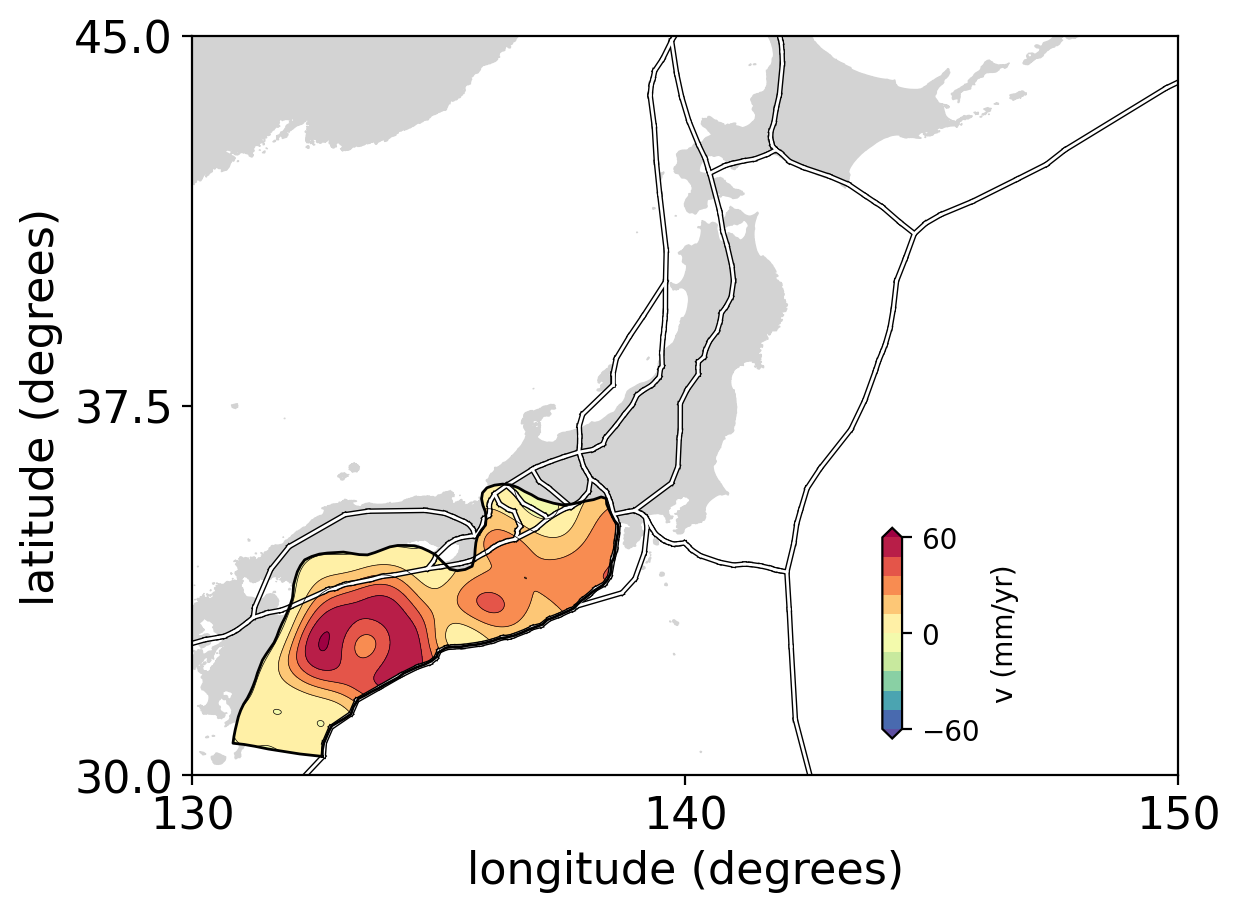

In [ ]:

def inpolygon(xq, yq, xv, yv):
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)


def rbf_interpolate(mesh_idx, fill_value, estimation, n_grid_x, n_grid_y):
    # Observation coordinates and data
    x_vec = np.linspace(estimation.model.meshes[mesh_idx].x_perimeter.min(), estimation.model.meshes[mesh_idx].x_perimeter.max(), n_grid_x)
    y_vec = np.linspace(estimation.model.meshes[mesh_idx].y_perimeter.min(), estimation.model.meshes[mesh_idx].y_perimeter.max(), n_grid_y)
    x_mat, y_mat = np.meshgrid(x_vec, y_vec)
    y_mat = y_mat
    centroids_lon = estimation.model.meshes[mesh_idx].centroids[:, 0]
    centroids_lat = estimation.model.meshes[mesh_idx].centroids[:, 1]
    centroids_val = fill_value

    # Package for RBFInterpolator
    xgrid = np.stack((x_mat, y_mat))
    xflat = xgrid.reshape(2, -1).T
    xobs = np.vstack((centroids_lon, centroids_lat)).T
    yobs = centroids_val
    yflat = RBFInterpolator(xobs, yobs, kernel="cubic", smoothing=0.01, epsilon=1.5)(
        xflat
    )
    ygrid = yflat.reshape(n_grid_x, n_grid_y)
    return xgrid, ygrid


def interpolate_to_mesh_masked_grid(mesh_idx, fill_value, estimation, n_grid_x, n_grid_y):
    # Interpolate (and extrapolate!) onto regular grid
    xgrid, ygrid = rbf_interpolate(mesh_idx, fill_value, estimation, n_grid_x, n_grid_y)

    # Set values outside of mesh perimeter to np.nan
    xflat = xgrid.reshape(2, -1).T
    inpolygon_vals = inpolygon(
        xflat[:, 0], xflat[:, 1], estimation.model.meshes[mesh_idx].x_perimeter, estimation.model.meshes[mesh_idx].y_perimeter
    )
    inpolygon_vals = np.reshape(inpolygon_vals, (n_grid_x, n_grid_y))
    ygrid[~inpolygon_vals] = np.nan
    
    return xgrid, ygrid


# Estimated dip-slip rates
mesh_idx = 0
max_vel = 60
levels = np.linspace(-max_vel, max_vel, 11)
n_grid_x = 500
n_grid_y = 500

# Interpolate onto regular grid
fill_value = estimation.tde_dip_slip_rates[mesh_start_idx[mesh_idx] : mesh_end_idx[mesh_idx]]
xgrid, ygrid = interpolate_to_mesh_masked_grid(mesh_idx, fill_value, estimation, n_grid_x, n_grid_y)


# Plot geometry with contoured mesh values
plot_segments(p, estimation.model.segment)
common_plot_elements(p)
plot_geography(p, geographic_lons, geographic_lats)
ch = plt.contourf(*xgrid, ygrid, cmap="Spectral_r", levels=levels, extend="both")
plt.contour(
    *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.25, levels=levels
)
plt.plot(estimation.model.meshes[mesh_idx].x_perimeter, estimation.model.meshes[mesh_idx].y_perimeter, "-k", linewidth=1.0)
plt.gca().set_aspect("equal", adjustable="box")
cax = inset_axes(
    plt.gca(),
    width="20%",
    height="30%",
    # loc="upper right",
    loc="lower left",
    bbox_to_anchor=(0.70, 0.05, 0.10, 0.95),  # Position in axes fraction
    bbox_transform=plt.gca().transAxes,
    borderpad=0,
)
cbar = plt.colorbar(ch, cax=cax, ticks=[-max_vel, 0, max_vel], label="v (mm/yr)")

# Kinematic rates (filled contour)

# Kinematic rates (smoothed, filled contour)

# Coupling (filled contour)

In [26]:
xgrid[0]

array([[130.823     , 130.83866333, 130.85432665, ..., 138.60767335,
        138.62333667, 138.639     ],
       [130.823     , 130.83866333, 130.85432665, ..., 138.60767335,
        138.62333667, 138.639     ],
       [130.823     , 130.83866333, 130.85432665, ..., 138.60767335,
        138.62333667, 138.639     ],
       ...,
       [130.823     , 130.83866333, 130.85432665, ..., 138.60767335,
        138.62333667, 138.639     ],
       [130.823     , 130.83866333, 130.85432665, ..., 138.60767335,
        138.62333667, 138.639     ],
       [130.823     , 130.83866333, 130.85432665, ..., 138.60767335,
        138.62333667, 138.639     ]], shape=(500, 500))